# Local Classifier 2 Sample Tests (C2ST) for conditional Normalizing Flows 


## Context & Objective
We consider a **conditional target density** $p(\theta \mid x)$ and **samples from the joint p.d.f** $\{\theta_i, x_i\} \sim p(\theta, x)$.

Our estimator is a **conditional Normalizing Flow** $q_{\phi}$ with base distribution $p(z) = \mathcal{N}(0,\mathbf{1}_m)$ and bijective transormation $T_{\phi}(.; x)$ defined on $\mathbb{R}^m$ and for all $x \in \mathbb{R}^d$.
    
- Its density can be explicilty evaluated using the inverse transformation:
    $$
    \forall \theta \in \mathbb{R}^m, \quad q_{\phi}(\theta \mid x) = p_{\mathcal{N}(0,\mathbf{1}_m)}(T_{\phi}^{-1}(\theta; x))\left|\operatorname{det} J_{T_{\phi}^{-1}}(\theta; x)\right|
    $$
    which means that flow can be trained via MLE on $N_1$ samples from the joint: 
$$\{\theta_i, x_i\}_{i=1}^{N_1} \sim p(\theta, x) \quad \rightarrow \quad \min_{\phi} -\frac{1}{N_1}\sum_{i=1}^N \log[q_{\phi}(\theta_i \mid x_i)] = -\frac{1}{N_1}\sum_{i=1}^N \log[p_{\mathcal{N}(0,\mathbf{1}_m)}(T_{\phi}^{-1}(\theta_i; x_i))\left|\operatorname{det} J_{T_{\phi}^{-1}}(\theta_i; x_i)\right|]$$

- We can sample from it using the forward transformation:
    $$z_i\sim p(z) = \mathcal{N}(0,\mathbf{1}_m) \quad \rightarrow \quad \theta^{\phi; x}_i = T_{\phi}(z_i; x)\sim q_{\phi}(\theta \mid x)$$
**GOAL:** Evaluate the ***local consistency of our estimator***, i.e. whether the following local null hypothesis holds for a fixed $x \in \mathbb{R}^d$
$$\mathcal{H}_0(x): p(\theta \mid x) = q_{\phi}(\theta \mid x), \quad \forall \theta \in \mathbb{R}^m$$



## Methodology 
**THEOREM: Local Consistency for NFs.** 
The local null hypothesis holds if, and only if, the inverse flow transformation applied to the target distribution recovers the base distribution. 

Using the same definition for $q_{\phi}$ as during sampling, $q_{\phi}(\theta \mid x) = p(T_{\phi}(z; x))$ (c.f. $T_{\phi}(z; x) \sim q_{\phi}(\theta \mid x)$ for $z\sim p(z)$), we have:
$$ p(\theta \mid x) = q_{\phi}(\theta \mid x) \iff p(T_{\phi}^{-1}(\theta; x)\mid x) = p(T_{\phi}^{-1}(T_{\phi}(z; x); x)) = p(z) = \mathcal{N}(0,\mathbf{1}_m)$$

**METHOD: Local C2ST.** 
We have a calibration dataset with $N_2$ samples from the joint $\{\theta_i, x_i\}_{i=1}^{N_2}$ (different than the data used to train the flow!)
1. Compute inverse flow-transformation: $T^{-1}_{\phi}(\theta_i,x_i)$

2. **Train classifier** to discriminate between the joint distributions $p(T^{-1}_{\phi}(\theta,x),x) = p(T^{-1}_{\phi}(\theta,x)\mid x)p(x)$ and $\mathcal{N}(0,1)p(x)$. This is a binary classification problem with 
    - **features** $[Z_i, x_i]$
    - **labels**: $Y = 0$, if $Z_i \sim \mathcal{N}(0,\mathbf{1}_m)$, $\quad Y=1$, if $Z_i = T^{-1}_{\phi}(\theta_i, x_i)$
    
3. **Evaluate consistency** for a given $x_0$, i.e. test whether $\mathcal{H}_0(x_0)$ holds: 
    
    - We evaluate the distribution of the predictive probability of belonging to class $0$ (normal distribution) $\hat{p}(Y=0\mid z,x_0)$ for $z\sim \mathcal{N}(0,\mathbf{1}_m)$ and fixed $x=x_0$: 
        - draw $z_i \sim \mathcal{N}(0,\mathbf{1}_m), i \in [1,N]$, 
        - evaluate the predictive probability of the trained classifier in the features $[z_i, x_0]$ (e.g. with the function `predict_proba` for `scikit-learn`-classifiers), 
        - ouput: a vector of samples $[\hat{p}(Y=0\mid z_1,x_0), \dots, \hat{p}(Y=0\mid z_N,x_0)]$ from the wanted distribution.
    
    - Under $\mathcal{H}_0(x_0)$, the discriminator should be completely uncertain about the predictive class, i.e. the predtictive probability should always be $0.5$, i.e. the distribution of the predictive probability (at $x_0$) should be a **dirac around $0.5$** (will be larger if not enough training samples, as unlikely datapoints that would not be covered by the training dataset could be considered out-of-distribution). 
    - Visualization:
        - histograms
        - PP-plots: c.d.f of the predicted probas vs. c.d.f of the dirac (step function)
    - Test statistics: 
        - total variation distance (TV_dist): euclidean distance between c.d.fs of predicted probas and dirac (step function)
        - wasserstein distance (w_dist) between dirac and predicted probas 

**Questions:**
- mathematical proof of the necessary and sufficient condition of the c2st test? 
- how to interpret the pp-plots of the predicted probabilities: what deviances from dirac indicate bias/dispersion? 

## Numerical illustration in 1D

In [1]:
# import libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os

import sys
sys.path.remove('/data/parietal/store/work/jlinhart/git_repos/HNPE')
sys.path.append('../../valDiags_flows/')

### Target density and Data Generation: 
Our target density is a 1D conditional gaussian ($m=1, d=2$):
$$p(\theta\mid x) = \mathcal{N}(x_1+x_2, 1), \quad x = (x_1, x_2) \sim \mathcal{N}(\mu, \Sigma)$$
where $\mu = [0, 0]$ and $\Sigma = \begin{pmatrix} 1 & 0.8\\ 0.8 & 1 \end{pmatrix}$.

This toy example is taken from [Zhao et al. (2021)].
Here, the "true" target distribution is exactly known: for any fixed $x_0 \in \mathbb{R}^2$ we can directly get samples $\theta_{x_0} \sim p(\theta \mid x_0) = \mathcal{N}(x_{0,1} + x_{0,2}, 1)$. Note however, that this is only used as a ground-truth reference: the density estimators (resp. validation metrics) are still being trained (resp. computed) on a dataset from the joint $\{\theta, x\} \sim p(\theta, x)$.

We chose this example to directly analyse the sensibility of validation diagnostics of conditional density estimators w.r.t. the context variable $x$, without any other influences on the result (e.g. introduced by the prior in SBI-context). 

Indeed, conditional density estimators can be valid on average over the $x$-space (global consistency), but be a bad approximators of the target distribution $p(\theta \mid x_0)$ at a specific location $x_0$ (local consistency). As done by [Zhao et al. (2021)] with the PIT, we will show that the vanilla C2ST, which only allows to measure global consistency, is invariant to covariate transforms in the $x$-space, whereas the proposed method ***local C2ST*** allows to detect the resulting local inconsistencies.

*Comment: this toy example is chosen outside of the SBI context* 
- *the simulator parameters $(\mu, \Sigma)$ are not what we want to estimate, i.e. the target variable $\theta$,*
- *there is no prior on the parameters $\theta$,*
- *the target distribution is not a posterior, just a "normal" conditional density (defined as a function of $x$)*

In [2]:
from data.data_generators import ConditionalGaussian1d

# Define Data Generator: 1D conditional gaussian
data_gen = ConditionalGaussian1d(mu=[0,0], sigma=[1,1], rho=0.8)

# Get train, cal and test datasets:
# - train samples are used to train the flow,
# - cal samples are used to learn the (unknown) PIT-distributions
# - test samples are used to evaluate the known and learned PIT-distributions 

train_size = 10_000  
cal_size = 5_000  
test_size = 1_000  

filename = '../saved_experiments/Gaussian1d/datasets.pkl'
if os.path.exists(filename):
    dataset = torch.load(filename)
    x_train, theta_train = dataset['train']
    x_cal, theta_cal = dataset['cal']
    x_test, theta_test = dataset['test']
else:
    x_train, theta_train = data_gen.get_joint_data(n=train_size)
    x_cal, theta_cal = data_gen.get_joint_data(n=cal_size)
    x_test, theta_test = data_gen.get_joint_data(n=test_size)
    dataset = {'train': [x_train, theta_train], 'cal': [x_cal, theta_cal], 'test': [x_test, theta_test]}
    torch.save(dataset, filename)

print("NB training samples: ", x_train.shape)
print("NB calibration samples: ", x_cal.shape)
print("NB test samples: ", x_test.shape)

NB training samples:  torch.Size([10000, 2])
NB calibration samples:  torch.Size([5000, 2])
NB test samples:  torch.Size([1000, 2])


### Density Estimation
We consider two NF-estimators:
- good MAF: trained on the full context variable $X=(X_1, X_2)$
- bad MAF: trained on a non-sufficient context $g(X)=X_1$

We will see that the global consistency check (on average over $x$-space, and not locally at a specific location $x=x_0$) is insensitive to the covariate transforms in $x$-space: Both estimators pass the test. 

The local consistency test however will show that the bad MAF is actually not a good approximation of the target density when evaluated at some fixed location $x=x_0$.

In [3]:
from nde.flows import construct_maf
from nde.train import train
from data.feature_transforms import first_dim_only, identity

# Good MAF...
maf_good = construct_maf(
    theta_train, hidden_features=50, context_features=2, standardize_transform=True, num_layers=5
)

# ... trained on X=(X_1,X_2)
filename = '../saved_experiments/Gaussian1d/maf_good.pkl'
if os.path.exists(filename):
    maf_good = torch.load(filename)
else:
    _, _ = train(
        maf_good,
        theta_train,
        context=x_train,  # X=(X_1,X_2)
        num_epochs=2000,
        batch_size=10,
        lr=0.005,
        validation=True,
        plot=False,
        epochs_until_converge=20,
    )

# Bad MAF...
maf_bad = construct_maf(
    theta_train, hidden_features=50, context_features=1, standardize_transform=True, num_layers=5
)

# ... trained on g(X)=(X_1)
g = first_dim_only
filename = '../saved_experiments/Gaussian1d/maf_bad.pkl'
if os.path.exists(filename):
    maf_bad = torch.load(filename)
else:
    _, _ = train(
        maf_bad,
        theta_train,
        context=g(x_train),  # g(X)=(X_1)
        num_epochs=2000,
        batch_size=10,
        lr=0.005,
        validation=True,
        plot=False,
        epochs_until_converge=20,
    )

torch.save(maf_good, '../saved_experiments/Gaussian1d/maf_good.pkl')
torch.save(maf_bad, '../saved_experiments/Gaussian1d/maf_bad.pkl')

### Evaluation of the trained flows using C2ST 
We use the `MLPClassifier` from `sklearn` with kwargs as specified in `sbi.utils.metrics` and 5000 calibration samples from the joint (this choice is motivated in the last section).

In [4]:
# Compute the inverse flow transformation on samples from the calibration set 
inv_flow_samples_cal_good = maf_good._transform(theta_cal, context=x_cal)[0].detach().numpy()
inv_flow_samples_cal_bad = maf_bad._transform(theta_cal, context=first_dim_only(x_cal))[0].detach().numpy()

# Generate data from the base / normal distribution 
from scipy.stats import norm
norm_samples = norm().rvs(cal_size)

#### 1. Global Consistency Check
We start by looking at the overall performance of our estimators: c2st score (i.e. cross-val accuracy) for a discrimination task between the inverse-flow distribution $p(T^{-1}_{\phi}(\theta; x))$ over the joint, and $\mathcal{N}(0,1)$. This gives us the expected performance over the $x$-space, and not for a specific location $x_0$. 

In [5]:
# Global test with mlp
from sbi.utils.metrics import c2st_scores
scores_good = c2st_scores(torch.tensor(inv_flow_samples_cal_good), torch.tensor(norm_samples[:,None]), n_folds=10)
scores_bad = c2st_scores(torch.tensor(inv_flow_samples_cal_bad), torch.tensor(norm_samples[:,None]), n_folds=10)
print('good:', np.mean(scores_good).__round__(2), '+/-', np.std(scores_good).__round__(2))
print('bad:', np.mean(scores_bad).__round__(2), '+/-', np.std(scores_bad).__round__(2))

good: 0.49 +/- 0.01
bad: 0.51 +/- 0.01


Both estimators (good and bad) show good average performance! 

As a reference we show the global PIT distribution as in [Zhao et al. (2021)]:

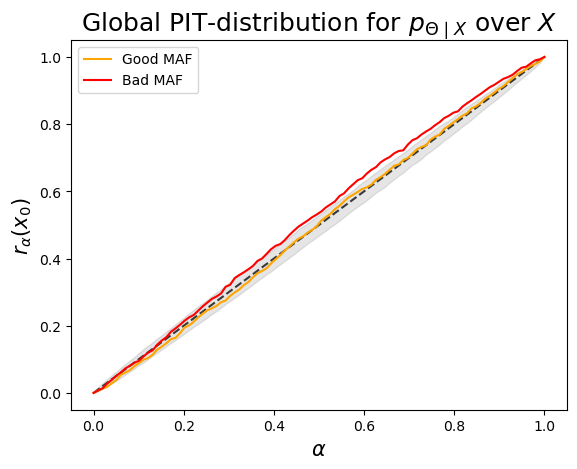

In [5]:
# PLOT GLOBAL/EXPECTED PIT-DISTRIBUTION of the trained estimators

from diagnostics.pp_plots import cde_pit_values, PP_plot_1D

# Compute PIT-values of the flows F_{Q|X_i}(Theta_i)
# [PIT(Theta_i, X_i, maf_good) = F_{Q_good|X_i}(Theta_i)]
flow_joint_pit_values_good = cde_pit_values(
    theta_test, x_test, maf_good, feature_transform=identity
)
# [PIT(Theta_i, X_i, maf_bad) = F_{Q_bad|X_i}(Theta_i)]
flow_joint_pit_values_bad = cde_pit_values(

    theta_test, x_test, maf_bad, feature_transform=first_dim_only
)

# PP-plot of global PIT-distribution for both flows
# alpha-quantiles = [P_X,Theta(Z < alpha)]
alphas = np.linspace(0,1,100)
PP_plot_1D(
    PIT_values=[flow_joint_pit_values_good, flow_joint_pit_values_bad],
    alphas=alphas,
    colors=["orange", "red"],
    labels=["Good MAF", "Bad MAF"],
    title=r"Global PIT-distribution for $p_{\Theta \mid X}$ over $X$",
    confidence_int=True,
)

#### 2. Local Consistency
We evaluate the true target density and the trained estimators in $x_0 = [0,1]$.

#### True and estimated densities at $x_0$

/data/parietal/store/work/jlinhart/git_repos/valDiags_flows/notebooks/../../valDiags_flows/plot.py:12: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1648016052946/work/aten/src/ATen/native/RangeFactories.cpp:20.)
  eval_x = torch.linspace(x_i, x_f).reshape(-1, 1)


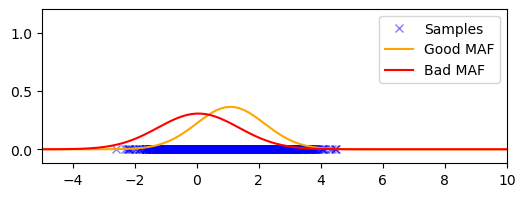

In [6]:
from plot import plot_pdf_1D

# Samples from the conditional distribution Theta|X=x_0
x_0 = torch.FloatTensor([[0, 1]])

samples_theta_x = torch.FloatTensor(
    [data_gen.sample_theta(x_0) for i in range(len(x_cal))]
).reshape(-1, 1)

# Plot PDF of trained flows evaluated in x_0
flows = {"Good MAF": (maf_good, x_0, "orange"), "Bad MAF": (maf_bad, x_0[:, 0], "red")}
plot_pdf_1D(samples_theta_x, x_i=-5, x_f=10, flows=flows)


- bad maf: negative bias and a little overdispersed
- good maf: seems fine, just a little positive bias.

This is can also be seen in the local PIT distribution that we can compute as a reference using the samples from the "true" target density at $x_0$, $p(\theta \mid x_0)$:

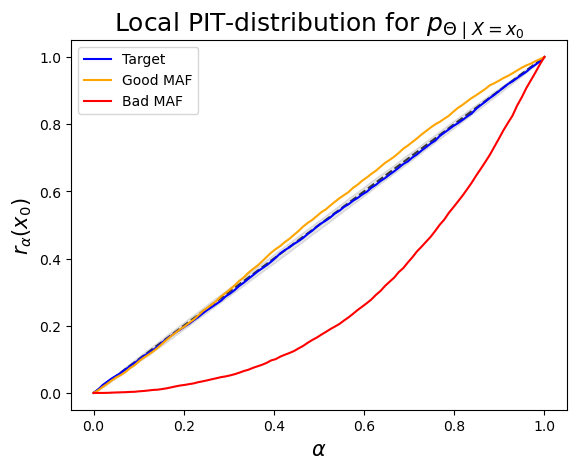

In [7]:
# Local PIT-distribution on samples Theta_{0,i} ~ Theta|X=x_0

# Compute PIT-values [PIT(Theta_{0,i}, X=x_0, p_true/good/bad) = F_{true/good/bad|x_0}(Theta_{0,i})]
true_local_pit_values = data_gen.true_pit_values(samples_theta_x, x_0, local=True)
flow_local_pit_values_good = cde_pit_values(
    samples_theta_x, x_0, flow=maf_good, feature_transform=identity, local=True
)
flow_local_pit_values_bad = cde_pit_values(
    samples_theta_x, x_0, flow=maf_bad, feature_transform=first_dim_only, local=True
)

# PP-plot of the local distribution
# alpha-quantiles = [P_{Theta|X}(Z < alpha)]
PP_plot_1D(
    PIT_values=[
        true_local_pit_values,
        flow_local_pit_values_good,
        flow_local_pit_values_bad,
    ],
    alphas=alphas,
    colors=["blue", "orange", "red"],
    labels=["Target", "Good MAF", "Bad MAF"],
    title=r"Local PIT-distribution for $p_{\Theta \mid X=x_0}$",
    confidence_int=True,
)

#### Local C2ST at $x_0$

##### Predict probas at $x_0$ 

You can run the following cell to obtain results directly for a certain number of trials by specifying `n_trials`...

In [16]:
# train classifier and predict probas for x_0
from diagnostics.localC2ST import local_flow_c2st, eval_local_flow_c2st

n_trials = 10
probas_good = []
probas_bad = []
probas_null = []

for t in range(n_trials): 
        # good and bad maf 
        # train classifiers 
        clf_good = local_flow_c2st(inv_flow_samples_cal_good, x_cal)
        clf_bad = local_flow_c2st(inv_flow_samples_cal_bad, x_cal)
        # predict probas 
        probas_good.append(eval_local_flow_c2st(clf_good, x_0[0], dim=1, n_rounds=1000))
        probas_bad.append(eval_local_flow_c2st(clf_bad, x_0[0], dim=1, n_rounds=1000))
        # null hypothesis
        # train classifier
        clf_null = local_flow_c2st(norm_samples[:,None], x_cal)
        # predict probas
        probas_null.append(eval_local_flow_c2st(clf_null, x_0[0], dim=1, n_rounds=1000))

... or load the precomputed results for `n_trials = 1000` obtained by running the same function in `script_margaret_local_c2st.py`:  

In [31]:
# Load pre-computed results...

# ... for good maf
filename_good = '../saved_experiments/Gaussian1d/lc2st_results/probas_good.pkl'
if os.path.exists(filename_good):
    probas_good = torch.load(filename_good)
# ... for bad maf
filename_bad = '../saved_experiments/Gaussian1d/lc2st_results/probas_bad.pkl'
if os.path.exists(filename_bad):
    probas_bad = torch.load(filename_bad)
    
# ... for null hypothesis
filename_null = '../saved_experiments/Gaussian1d/lc2st_results/probas_null.pkl'
if os.path.exists(filename_bad):
    probas_null = torch.load(filename_null)
    

##### Plot histograms 

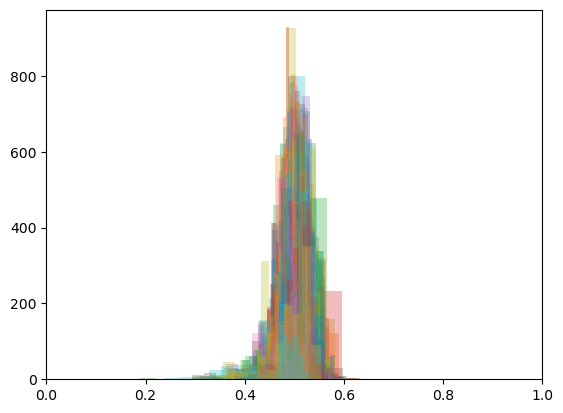

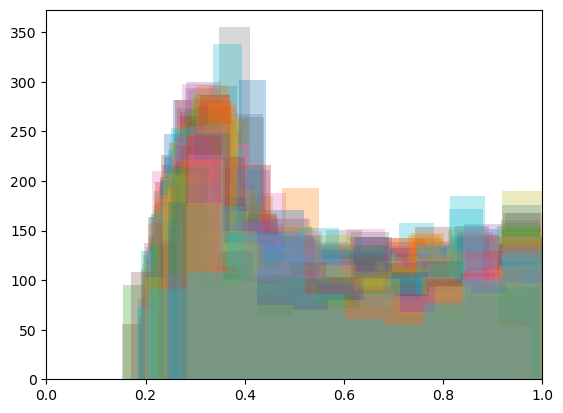

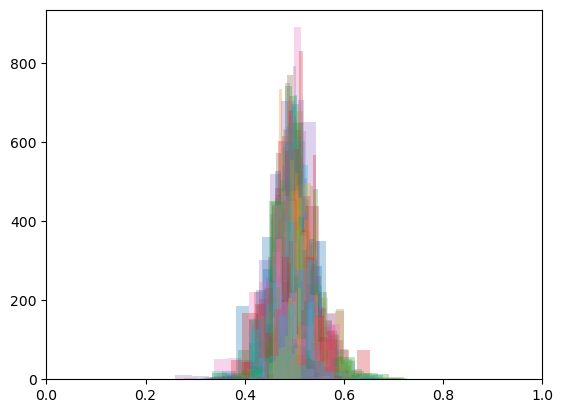

In [11]:
n_trials = 1000

for t in range(n_trials):
    plt.hist(probas_good[t],alpha=0.3)
plt.xlim(0,1)
plt.show()

for t in range(n_trials):
    plt.hist(probas_bad[t],alpha=0.3)
plt.xlim(0,1)
plt.show()

for t in range(n_trials):
    plt.hist(probas_null[t],alpha=0.3)
plt.xlim(0,1)
plt.show()

##### Hyptothesis Test Diagnostics (evaluate w.r.t null-hypothesis)

1. Total variation (TV): distribution (c.d.f.) of predicted probas 

The associated test-statistic (TV_dist) is the euclidean distance to the c.d.f of the dirac function at $0.5$ (step function in black dashed line).

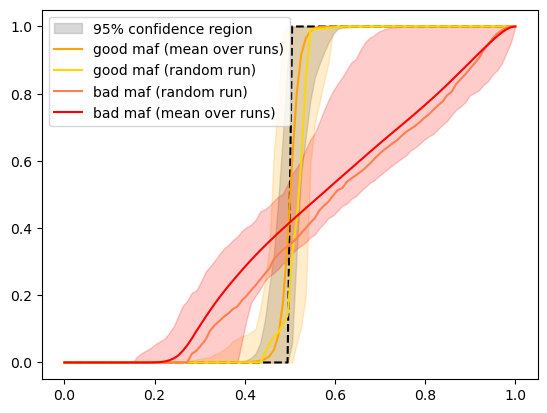

Test statistics and p-values for the chosen random run:

test stat good :  0.01031593
p-value good :  0.183

test stat bad :  0.07670701
p-value bad :  0.0


In [15]:
from diagnostics.pp_plots import PP_vals

random_run_idx = np.random.randint(0,1000)

alphas = np.linspace(0,1,100)
pp_vals_dirac = PP_vals([0.5]*1000, alphas)
plt.plot(alphas, pp_vals_dirac, '--', color='black')

pp_vals_null = {}
test_stats_null = {}
for t in range(len(probas_null)):
    pp_vals_null[t] = pd.Series(PP_vals(probas_null[t], alphas))
    test_stats_null[t] = ((pp_vals_null[t]- pp_vals_dirac) ** 2).sum() / len(alphas)

pp_vals_good = {}
pp_vals_bad = {}
test_stats_good = {}
test_stats_bad = {}
for t in range(len(probas_null)):
    pp_vals_good[t] = pd.Series(PP_vals(probas_good[t], alphas))
    pp_vals_bad[t] = pd.Series(PP_vals(probas_bad[t], alphas))
    test_stats_good[t] = ((pp_vals_good[t]- pp_vals_dirac) ** 2).sum() / len(alphas)
    test_stats_bad[t] = ((pp_vals_bad[t]- pp_vals_dirac) ** 2).sum() / len(alphas)

low_null = pd.DataFrame(pp_vals_null).quantile(0.05/2, axis=1)
up_null = pd.DataFrame(pp_vals_null).quantile(1-0.05/2, axis=1)
plt.fill_between(alphas, low_null, up_null, color="grey", alpha=0.3, label='95% confidence region')

low_good = pd.DataFrame(pp_vals_good).min(axis=1)
up_good = pd.DataFrame(pp_vals_good).max(axis=1)
line_good = pd.DataFrame(pp_vals_good).mean(axis=1)
plt.plot(alphas, line_good, label='good maf (mean over runs)', color='orange')
plt.plot(alphas, pp_vals_good[random_run_idx], color='gold', label='good maf (random run)')
plt.fill_between(alphas, low_good, up_good, color="orange", alpha=0.2)

low_bad = pd.DataFrame(pp_vals_bad).min(axis=1)
up_bad = pd.DataFrame(pp_vals_bad).max(axis=1)
line_bad = pd.DataFrame(pp_vals_bad).mean(axis=1)
plt.plot(alphas, pp_vals_bad[random_run_idx], color='coral', label='bad maf (random run)')
plt.plot(alphas, line_bad, label='bad maf (mean over runs)', color='red')
plt.fill_between(alphas, low_bad, up_bad, color="red", alpha=0.2)
plt.legend()
plt.show()


# Test statistics and p-values for the chosen random run 
print('Test statistics and p-values for the chosen random run:')
print()
test_stat_good = ((pp_vals_good[random_run_idx] - pp_vals_dirac) ** 2).sum() / len(alphas)
p_value_good = sum(1 * (test_stat_good < pd.Series(test_stats_null))) / len(test_stats_null)
print('test stat good : ', test_stat_good)
print('p-value good : ', p_value_good)
print()

test_stat_bad = ((pp_vals_bad[random_run_idx] - pp_vals_dirac) ** 2).sum() / len(alphas)
p_value_bad = sum(1 * (test_stat_bad < pd.Series(test_stats_null))) / len(test_stats_null)
print('test stat bad : ', test_stat_bad)
print('p-value bad : ', p_value_bad)

2. Wasserstein distance (w_dist) between dirac and predicted probas for class 0

This metric was introduced because we found that in some cases (c.f. `JRNMM.ipynb`) where the confidence region is quite large the distance to the heaviside step function is maybe not the best: even under the null hypothesis values can get high (e.g. higher than for the uniform distribution that will thus not be rejected) as the discontinuity will yield several values will be at or close to the max distance of 1.

In [16]:
from scipy.stats import wasserstein_distance
w_dist_good = [wasserstein_distance([0.5]*1000, probas_good[t]) for t in range(1000)]
w_dist_bad = [wasserstein_distance([0.5]*1000, probas_bad[t]) for t in range(1000)]
w_dist_null = [wasserstein_distance([0.5]*1000, probas_null[t]) for t in range(1000)]

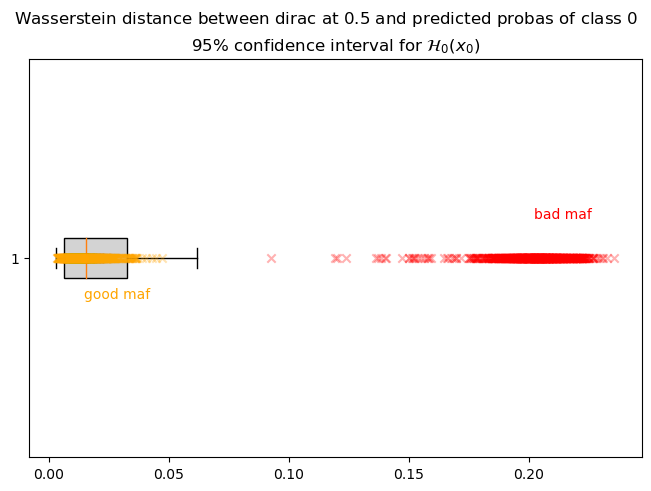

Test statistics and p-values for the chosen random run:

good maf:
test stat:  0.024092678954413346
p_value:  0.175
bad maf:
test stat:  0.19948456467725623
p_value:  0.0


In [17]:
import matplotlib.cbook as cbook

data = w_dist_null
stats = cbook.boxplot_stats(data)[0]
stats['q1'] = np.quantile(data, 0.05)
stats['q3'] = np.quantile(data, 0.95)
stats['whislo'] = min(data)
stats['whishi'] = max(data)

fig, ax = plt.subplots(1, 1, constrained_layout=True)
bp = ax.bxp([stats],widths=0.1, vert=False, showfliers=False, patch_artist=True)
bp['boxes'][0].set_facecolor('lightgray')

plt.text(np.mean(w_dist_good), 0.9, 'good maf', color='orange')
plt.scatter(np.mean(w_dist_good), 1, color='orange', zorder=10)
for a in w_dist_good:
    plt.scatter(a, 1, marker='x', color='orange', zorder=10, alpha=0.3)
plt.text(np.mean(w_dist_bad), 1.1, 'bad maf', color='red')
plt.scatter(np.mean(w_dist_bad), 1, color='red')
for a in w_dist_bad:
    plt.scatter(a, 1, marker='x', color='red', zorder=11, alpha=0.3)

p_value_good = sum(1 * (w_dist_good[random_run_idx] < pd.Series(w_dist_null))) / len(w_dist_null)
p_value_bad = sum(1 * (w_dist_bad[random_run_idx] < pd.Series(w_dist_null))) / len(w_dist_null)

# plt.legend()
plt.title(r'95% confidence interval for $\mathcal{H}_0(x_0)$')
plt.suptitle(r'Wasserstein distance between dirac at $0.5$ and predicted probas of class 0')
plt.show()
print('Test statistics and p-values for the chosen random run:')
print()
print('good maf:')
print('test stat: ', w_dist_good[random_run_idx])
print('p_value: ', p_value_good)
print('bad maf:')
print('test stat: ', w_dist_bad[random_run_idx])
print('p_value: ', p_value_bad)

#### Interpretability: where can the classifier discriminate (or not)?
(cf. [Lee et al. (2018)])

The distributions we which to compare with this local C2ST test are the $p(z \mid x_0)$ where $z = T_{\phi}^{-1}(\theta; x_0)$ or $z \sim \mathcal{N}(0,1)$
- the true distribution at $x_0$ of the inverse transformation at $x_0$ (for good and bad maf): $p(T_{\phi}^{-1}(\theta; x_0)\mid x_0)$
- the normal distribution $\mathcal{N}(0,1)$

Using the samples from the true conditional distribution $p(\theta \mid x_0)$ (which we only have in this toy example and not in a regular sbi setting), we can get samples from the inverse transformations and plot the histograms.

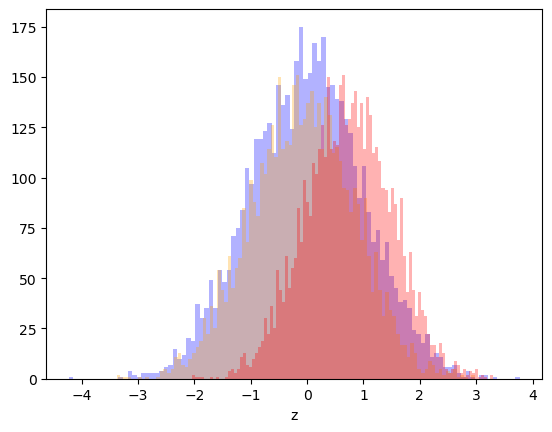

In [27]:
# Hist of the distributions: norm, inv-flow good/bad
inv_flow_samples_true_good = maf_good._transform(samples_theta_x, context=x_0)[0].detach().numpy()
inv_flow_samples_true_bad = maf_bad._transform(samples_theta_x, context=first_dim_only(x_0))[0].detach().numpy()
plt.hist(norm_samples, bins=100, color='blue', alpha=0.3)
plt.hist(inv_flow_samples_true_good, bins=100, color='orange', alpha=0.3)
plt.hist(inv_flow_samples_true_bad, bins = 100, color='red', alpha=0.3)
plt.xlabel('z')
plt.show()

This shows us what we should expect from our predicted probabilities: regions where the norm pdf (blue) nis higher than the other (orange or red), the predicted probas should be above 0.5, otherwise they should be below 0.5. 

It relates to the exact opposite case of what we saw in the pdf plot of the learned distributions at $x_0$: 
- negative bias becomes positive bias
- overdispersion becomes underdispersion

WHY? inverse transformation? always the case? just inverse affine transformation...?


In [ ]:
# train classifier and predict probas for x_0 over a grid
from diagnostics.localC2ST import local_flow_c2st, eval_local_flow_c2st

grid = np.linspace(-5,5,1000).reshape(-1,1)
features_eval = np.concatenate([grid, x_0[0].repeat(1000,1)], axis=1)

n_trials = 10
probas_grid_good = []
probas_grid_bad = []
probas_grid_null = []

for t in range(n_trials): 
        # good and bad maf 
        # train classifiers 
        clf_good = local_flow_c2st(inv_flow_samples_cal_good, x_cal)
        clf_bad = local_flow_c2st(inv_flow_samples_cal_bad, x_cal)
        # predict probas 
        probas_grid_good.append(clf_good.predict_proba(features_eval)[:,0])
        probas_grid_bad.append(clf_bad.predict_proba(features_eval)[:,0])
        # null hypothesis
        # train classifier
        clf_null = local_flow_c2st(norm_samples[:,None], x_cal)
        # predict probas
        probas_grid_null.append(clf_null.predict_proba(features_eval)[:,0])

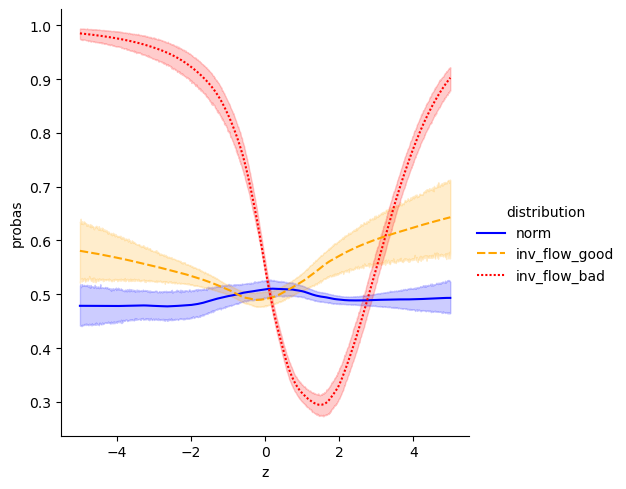

In [24]:
# plot predicted probas over grid
probas = np.concatenate(
    [
        np.concatenate(probas_grid_null),
        np.concatenate(probas_grid_good),
        np.concatenate(probas_grid_bad),
    ]
)
grids = np.concatenate([grid]*30)
names = ['norm']*10000+['inv_flow_good']*10000+['inv_flow_bad']*10000

df = pd.DataFrame({'distribution': names, 'probas': probas, 'z': grids[:,0]})

import seaborn as sns
sns.relplot(
        data=df, x="z", y="probas",
        hue="distribution", style="distribution", kind="line", palette=['blue','orange','red']
    )
plt.show()

Results:
- red (bad): high probas (>0.5) until $z\approx0.5$ (which is where the norm pdf is indeed higher) and low probas (<0.5) between $z\approx 0.5$ and $z\approx2.5$ (which is where the red pdf is higher), then high probas again but at the border of the norm pdf support... (could indicate underdispersion)
- orange (good): pretty insignificant probas (around 0.5) a little drop at $z=0^-$, and higher probas at the borders of the norm pdf (again underdispersion..?)
- blue (norm/null): always around 0.5.

The location of the peak of the low-probas indicates positive/negative bias (in 1D at least). 

In higher dimensions we cannot talk/conclude about bias or over/underdispersion, but we can identify the regions where one or the other pdf in higher, and where they are equal. 

### Choice of classification model cal-set size

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

import torch.distributions as D
import time

#### Accuracy - Shift experiment - Model choice
We compute the global cross-val c2st accuracy score between two 1D gaussians: 
- Reference: $\quad \mathcal{N}(0,1)$
- Gaussian with shifted mean or std: $\quad \mathcal{N}(m,1), m \in [0,10] \quad$ or $\quad \mathcal{N}(0,s), s \in [1,20]$

The classifiers are trained on samples of the joint: $[z_i, x_i]$ where the $z_i$ correspond to samples from the reference or the other gaussian distribution with lables 0 or 1.

The ground truth (i.e objectively best discriminator which recovers the analytic response) is obtained via LDA (resp. QDA) in the mean-shift (resp. scale-shift) experiment.

*Comment: If several classifiers have similar permormance, we can also look at the total cv time.*

##### Experimental SET-UP

In [37]:
from diagnostics.c2st_scores_modified import c2st_scores 
# modified version to allow classifiers like `'lda'` and `'qda'` where no random seed is defined for the `clf_kwargs`. 

def eval_classifier_for_lc2st(x_samples, ref_samples, shifted_samples, shifts, clf_class, clf_kwargs, nfolds=10):
    ref_joint_samples = torch.cat([ref_samples,x_samples], dim=1)
    shift_list = []
    scores = []
    times = []
    for s_samples,s in zip(shifted_samples, shifts):
        s_joint_samples = torch.cat([s_samples, x_samples], axis=1)
        start = time.time()
        cross_val_scores = c2st_scores(ref_joint_samples, s_joint_samples, n_folds=nfolds, clf_class=clf_class, clf_kwargs=clf_kwargs)
        total_cv_time = time.time() - start
        for t in range(nfolds):
            shift_list.append(s)
            scores.append(cross_val_scores[t])
            times.append(total_cv_time)
    return shift_list, scores, times

In [35]:
N_list = [1000, 2000, 5000]
mean_shifts = [0, 0.3, 0.6, 1, 1.5, 2, 2.5, 3, 5, 10]
scale_shifts = np.linspace(1, 20, 10)

# Datasets
x_samples = {}
ref_samples = {}
for n in N_list:
    x_samples[n] = data_gen.sample_x(n)
    ref_samples[n] = D.MultivariateNormal(
        loc=torch.zeros(1), covariance_matrix=torch.eye(1)
    ).rsample((n,))

mean_shifted_samples = {}
scale_shifted_samples = {}
for n in N_list:
    mean_shifted_samples[n] = [
        D.MultivariateNormal(
            loc=torch.FloatTensor([m]), covariance_matrix=torch.eye(1)
        ).rsample((n,))
        for m in mean_shifts
    ]
    scale_shifted_samples[n] = [
        D.MultivariateNormal(
            loc=torch.zeros(1), covariance_matrix=torch.eye(1) * s
        ).rsample((n,))
        for s in scale_shifts
    ]

# Models
ndim = x_samples[1000].shape[-1] + ref_samples[1000].shape[-1]
clf_classes = {
    "mlp_base": MLPClassifier,
    "mlp_sbi": MLPClassifier,
    "rf": RandomForestClassifier,
    "logreg": LogisticRegression,
    "lda": LinearDiscriminantAnalysis,
    "qda": QuadraticDiscriminantAnalysis,
}
clf_kwargs_dict = {
    "mlp_base": {},
    "mlp_sbi": {
        "activation": "relu",
        "hidden_layer_sizes": (10 * ndim, 10 * ndim),
        "max_iter": 1000,
        "solver": "adam",
        "early_stopping": True,
        "n_iter_no_change": 50,
    },
    "rf": {},
    "logreg": {},
    "lda": {},
    "qda": {},
}

##### Mean shifts

In [38]:
clf_names = ["mlp_sbi", "rf", "lda", "logreg"]

filename = '../saved_experiments/Gaussian1d/lc2st_eval_clfs/dfs_mean.pkl'
if os.path.exists(filename):
    dfs_mean = torch.load('../saved_experiments/Gaussian1d/lc2st_eval_clfs/dfs_mean.pkl')
    for n in N_list:
        dfs_mean[n] = dfs_mean[n][dfs_mean[n]['classifier'].isin(clf_names)]
else:
    dfs_mean = {}
    for n in N_list:
        dfs = []
        for clf_name in clf_names:
            shift_list, scores, times = eval_classifier_for_lc2st(
                x_samples[n],
                ref_samples[n],
                shifted_samples=mean_shifted_samples[n],
                shifts=mean_shifts,
                clf_class=clf_classes[clf_name],
                clf_kwargs=clf_kwargs_dict[clf_name],
            )
            clf_method = [clf_name]*len(shift_list)
            dfs.append(pd.DataFrame({'mean_shift': shift_list, 'accuracy': scores, 'total_cv_time':times, 'classifier':clf_method}))
        dfs_mean[n] = pd.concat(dfs, ignore_index=True)

    torch.save(dfs_mean, '../saved_experiments/Gaussian1d/lc2st_eval_clfs/dfs_mean.pkl')


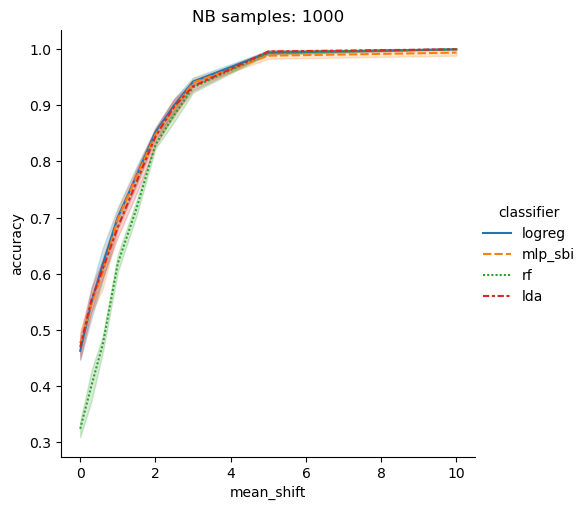

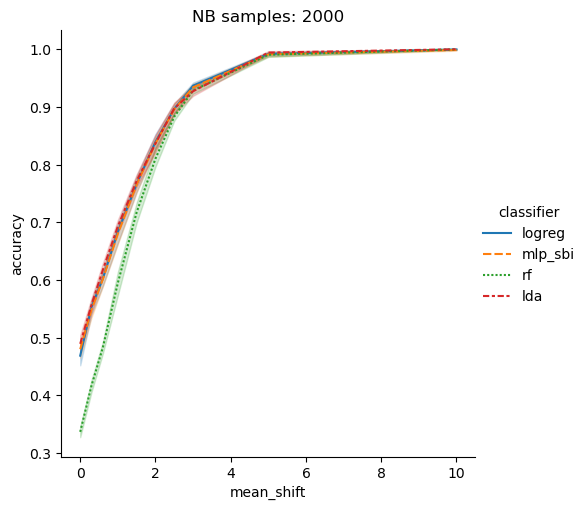

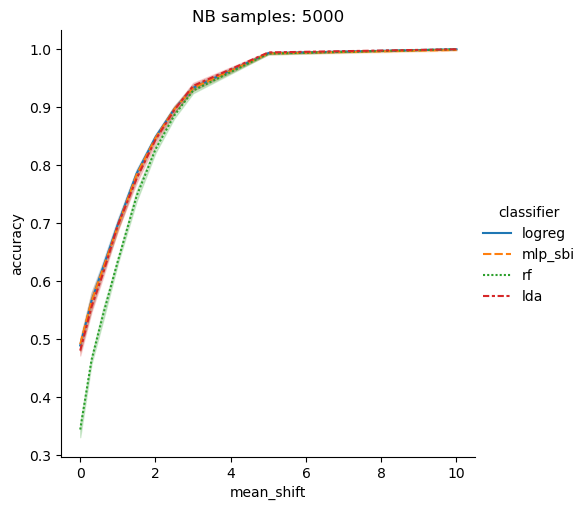

In [51]:
import seaborn as sns
for n in N_list:
    sns.relplot(
        data=dfs_mean[n], x="mean_shift", y="accuracy",
        hue="classifier", style="classifier", kind="line",
    )
    plt.title(f'NB samples: {n}')
    plt.show()

##### Scale Shifts

In [52]:
clf_names = ["mlp_sbi", "rf", "qda", "logreg"]

filename = '../saved_experiments/Gaussian1d/lc2st_eval_clfs/dfs_scale.pkl'
if os.path.exists(filename):
    dfs_scale = torch.load('../saved_experiments/Gaussian1d/lc2st_eval_clfs/dfs_scale.pkl')
    for n in N_list:
        dfs_scale[n] = dfs_scale[n][dfs_scale[n]['classifier'].isin(clf_names)]
else:
    dfs_scale = {}
    for n in N_list:
        dfs = []
        for clf_name in clf_names:
            shift_list, scores, times = eval_classifier_for_lc2st(
                x_samples[n],
                ref_samples[n],
                shifted_samples=scale_shifted_samples[n],
                shifts=scale_shifts,
                clf_class=clf_classes[clf_name],
                clf_kwargs=clf_kwargs_dict[clf_name],
            )
            clf_method = [clf_name]*len(shift_list)
            dfs.append(pd.DataFrame({'scale_shift': shift_list, 'accuracy': scores, 'total_cv_time':times, 'classifier':clf_method}))
        dfs_scale[n] = pd.concat(dfs, ignore_index=True)

    torch.save(dfs_scale, '../saved_experiments/Gaussian1d/lc2st_eval_clfs/dfs_scale.pkl')

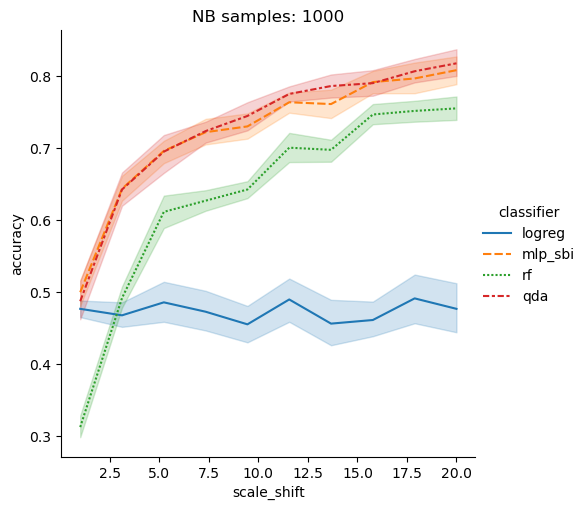

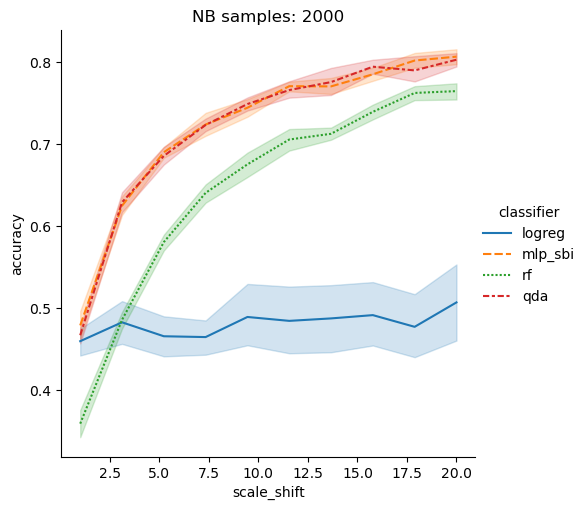

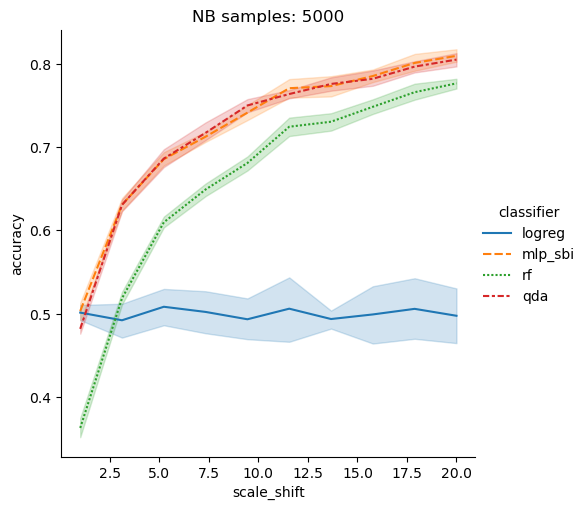

In [53]:
for n in N_list:
    sns.relplot(
        data=dfs_scale[n], x="scale_shift", y="accuracy",
        hue="classifier", style="classifier", kind="line",
    )
    plt.title(f'NB samples: {n}')
    plt.show()

We choose the MLP classifier with hyperparameters as in `sbi.utils.metrics`. It performs best in both (mean AND scale-shift) experiments. The scale-shift experiment suggests that a larger sample size results in smoother curves and less varaiance over the cross-val folds. FOr a sample size of 1000, the mlp curve in orange is still not close enough too the reference curve of QDA in red. It is better for 2000 and almost perfect for 5000. We therefore suggest a sample size of 5000 (2000 should also be okay).. 

#### Precision under the null hypothesis - cal set size 

For different cal set sizes we compute the cross-val test statistics (distance to dirac c.d.f) and stds of the predicted distribution (output of `eval_local_flow_c2st`) under the null hypothesis.

We relax the problem from a dirac to a gaussian distribution with std of 0.05 or 0.1 (smooth dirac):
- we compute the theoretical test-statistics of those two gaussians 
- we compare the obtained test-statistics and stds of the cross-validation to these theoretical values

##### Theoretical Test-stats for chosen stds

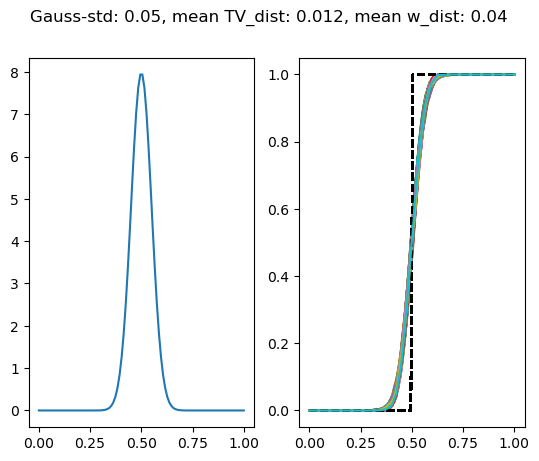

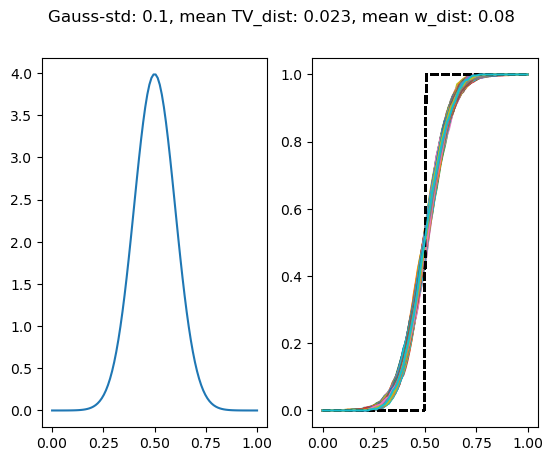

In [19]:
from diagnostics.pp_plots import PP_vals
from scipy.stats import wasserstein_distance

def smooth_dirac(eps=0.1):
    return norm(loc=0.5,scale=eps)

alphas = np.linspace(0,1,100)
pp_vals_dirac = PP_vals([0.5]*1000, alphas)
for e in [0.05, 0.1]:
    fig, axs = plt.subplots(1,2)
    axs[0].plot(alphas,[smooth_dirac(eps=e).pdf(x) for x in alphas])

    pp_vals_dirac = PP_vals([0.5]*1000, alphas)

    test_stats = []
    w_dist = []
    for t in range(1000):
        samples = smooth_dirac(eps=e).rvs(1000)
        pp_vals = pd.Series(PP_vals(samples, alphas))
        test_stats.append(((pp_vals - pp_vals_dirac) ** 2).sum() / len(alphas))
        w_dist.append(wasserstein_distance([0.5]*1000, samples))
        axs[1].plot(alphas, pp_vals_dirac, '--', color='black')
        axs[1].plot(alphas, pp_vals)
    plt.suptitle(f'Gauss-std: {e}, mean TV_dist: {np.round(np.mean(test_stats),3)}, mean w_dist: {np.round(np.mean(w_dist),3)}')
    plt.show()

##### Experimental SETUP

In [ ]:
from diagnostics.localC2ST import local_flow_c2st, eval_local_flow_c2st
from sklearn.model_selection import KFold

def eval_clf_null(x_samples, dim=1, n_list=[1000], classifiers=['mlp'], n_trials=100):

    alphas = np.linspace(0,1,100)
    pp_vals_dirac = PP_vals([0.5]*1000, alphas)

    nb_samples = []
    probas_stds = []
    test_stats = []
    w_dist = []
    times = []
    clf_method = []

    for n in n_list:
        Q = D.MultivariateNormal(loc=torch.FloatTensor([0]*dim), covariance_matrix=torch.eye(dim)).rsample((n,))
        kf = KFold(n_splits=n_trials, shuffle=True, random_state=1)
        for clf_name in classifiers:
            start = time.time()
            for t, (train_index, test_index) in enumerate(kf.split(x_samples[n])):
                x_samples_train = x_samples[n][train_index]
                x_samples_test = x_samples[n][test_index]
                Q_train = Q[train_index]
                Q_test = Q[test_index]
                clf = local_flow_c2st(Q_train, x_samples_train, classifier=clf_name)
                std_x = []
                test_stats_x = []
                w_dist_x = []
                for i,x_obs in enumerate(x_samples_test):
                    proba = eval_local_flow_c2st(clf, x_obs, dim=dim, n_rounds=1000)
                    pp_vals = pd.Series(PP_vals(proba, alphas))
                    test_stats_x.append(((pp_vals - pp_vals_dirac) ** 2).sum() / len(alphas))
                    w_dist_x.append(wasserstein_distance([0.5]*1000, proba))
                    std_x.append(np.std(proba))
                probas_stds.append(np.mean(std_x))
                test_stats.append(np.mean(test_stats_x))
                w_dist.append(np.mean(w_dist_x))
                nb_samples.append(n)
    
            total_cv_time = time.time() - start
            for t in range(n_trials):
                times.append(total_cv_time)
                clf_method.append(clf_name)
    df = pd.DataFrame({f'nb_samples': nb_samples, 'probas_std': probas_stds, 'test_stats': test_stats, 'w_dist': w_dist, 'total_cv_time':times, 'classifier':clf_method,})
    # filename = f'saved_experiments/Gaussian1d/lc2st_eval_clfs/df_null_std_cv_n_{n_list}_ntrials_{n_trials}_Tstats_wdist.pkl'
    # torch.save(df, filename)
    return df

In [40]:
N_LIST = [1000, 2000, 3000, 5000, 6000, 10000]

data_gen = ConditionalGaussian1d()
x_samples = {}
for n in N_LIST:
    x_samples[n], _ = data_gen.get_joint_data(n=n)

##### Results

You can run the following cell to obtain results directly for a certain number of trials and sample sizes by specifying `n_trials` and `N_LIST`...

In [42]:
dfs = []
for n in N_LIST[:1]:
    dfs.append(eval_clf_null(x_samples, n_list=[n], n_trials=2))

... or load the precomputed results for all sample sizes and `n_trials = 100` obtained by running the same funtion in `script_margaret_local_c2st.py`:  

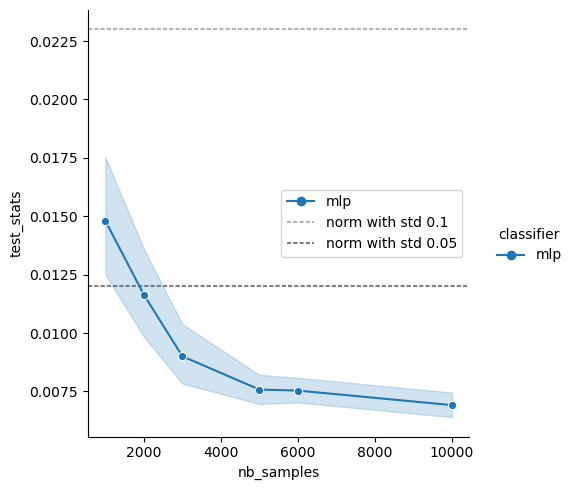

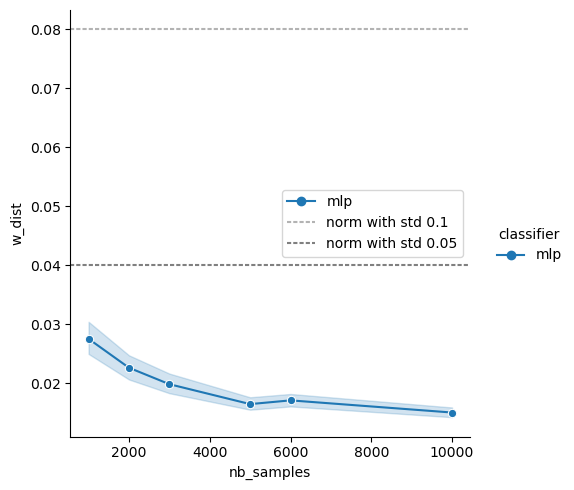

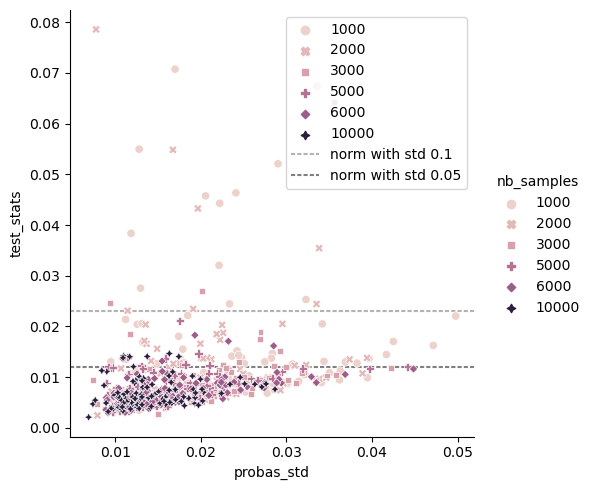

0.049785141859752094 0.044852519054413294


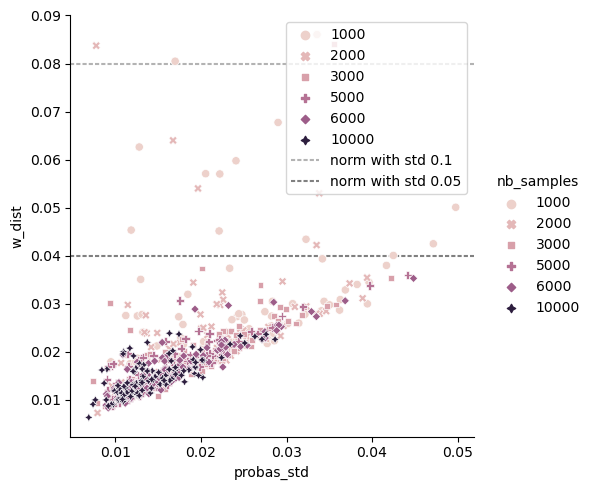

0.049785141859752094 0.044852519054413294


In [60]:
import seaborn as sns

dfs = []
for n in N_LIST:
    dfs.append(torch.load(f'../saved_experiments/Gaussian1d/lc2st_eval_clfs/df_null_std_cv_n_[{n}]_ntrials_100_Tstats_wdist.pkl'))

df = pd.concat(dfs, ignore_index=True)
for T, y1, y2 in zip(['test_stats', 'w_dist'], [0.023,0.08], [0.012, 0.04]):
    g = sns.relplot(
            data=df, x="nb_samples", y=T,
            hue="classifier", style="classifier", kind="line", markers='o'
        )
    g.map(plt.axhline, y=y1, color=".7", dashes=(2, 1), zorder=0, label='norm with std 0.1')
    g.map(plt.axhline, y=y2, color=".5", dashes=(2, 1), zorder=0, label='norm with std 0.05')
    plt.legend()
    plt.show()


for T, y1, y2 in zip(['test_stats', 'w_dist'], [0.023,0.08], [0.012, 0.04]):
    g = sns.relplot(
            data=df, x="probas_std", y=T,
            hue="nb_samples", style="nb_samples", kind="scatter", 
        )
    g.map(plt.axhline, y=y1, color=".7", dashes=(2, 1), zorder=0, label='norm with std 0.1')
    g.map(plt.axhline, y=y2, color=".5", dashes=(2, 1), zorder=0, label='norm with std 0.05')
    plt.legend()
    plt.show()
    print(df[df[T]<=y1]['probas_std'].max(), df[df[T]<=y2]['probas_std'].max())

Results:
- plot 1/2: the wanted theoretical test statistic value is obtained for a sample size of 2-3_000 (for 0.05 std) and always for 0.1 std. It is always obtained if the test statistic is the wasserstein distance.
- plot 3/4: Larger sample sizes ensure small test statistics for small stds (closer to theory). There are no data points that deviate from the theory (see printed max stds below plot that are respectively smaller than 0.1 and 0.05). The wasserstein distance is almost never above the theoretical one, compared to the c.d.f test-statistic. 

1. The wasserstein distance seems to lead to statistically more powerful tests (less data needed to get narrow confidence regions).

2. What sample size do we chose? The smallest to obtain a good accuracy curve in the shift-experiment AND test statistics below a chose theoretical reference gaussian (0.1 or 0.05 std). 

    We chose 5000 because it gave the smoothest and most precise curve in the scale-shift experiment. But looking at the above plots for the "total variation" test-statistic (distance between c.d.fs), we could also try a sample size of 2000-3000 (which is where we get to the theoretical value associated to the gaussian with 0.05 std).

## Application to a real SBI example: the JR-NMM

- Prior: `torch.Size([1, 4])`
    $$p(\theta) = \mathcal{U}([10,250], [50,500], [100,5000],[-20,20])$$
- Simualtor (JR-NMM): `torch.Size([1, 1024])`
    $$\text{Simulator}(\theta) = x \sim p(x\mid \theta) \text{, where} \theta = (C, \mu, \sigma, g)$$
- Summary Statistics (Fourier log Power Spectral Density): `torch.Size([1, 33])`
    $$s(x) = \text{log-PSD}(x)$$
    For simplicity, we use the notation $x$ when we actually refer to $s(x)$.
    
**GOAL:** Evaluate the estimated posterior in an observation $x_0$ and check how close this approximation is to the true unknown true density $p(\theta \mid x_0)$. 

**METHOD:** Because we are in a multivariate case ($\theta$ does not live in 1D, but 4D), the local PIT [Zhao et al. (2021)] is not applicable. We will directly use our method, ***local C2ST***. 

In this notebook we directly load precomputed results (long running time), details can be found in the notebook `JRNMM.ipynb`.

### Density Estimator 
Normalizing Flow (MAF) with 10 layers $q_{\phi}(\theta\mid x) \approx p(\theta\mid x)$ trained on $50 000$ samples from the joint:
$$\theta_i \sim p(\theta), x_i = \text{Simulator}(\theta_i) \sim p(x \mid \theta_i) \quad \rightarrow \quad \theta_i,x_i \sim p(\theta, x)$$ 
We load the pretrained NF, obtained by running `script_margaret_trainHNPE_sim.py`.

In [3]:
filename = f'../saved_experiments/JR-NMM/posteriors_amortized/naive_posterior_nextra_0_single_rec_False_nsim_50000.pkl'
posterior_est = torch.load(filename)

### Evaluation of the trained estimator

#### Global consistency check
We here use a pre-simulated calibration set of size $10000$.

In [4]:
# Load simulated Data
filename = f"../saved_experiments/JR-NMM/datasets_naive.pkl"
datasets = torch.load(filename)
x_cal, theta_cal = datasets['B_prime']['x'], datasets['B_prime']['theta'] # 10_000
x_cal.shape, theta_cal.shape

(torch.Size([10000, 33, 1]), torch.Size([10000, 4]))

In [5]:
# Compute Global c2st score
from sbi.utils.metrics import c2st_scores
import torch.distributions as D

flow_values_cal = posterior_est._transform(theta_cal, context=x_cal)[0].detach()
norm_samples = D.MultivariateNormal(torch.zeros(4), torch.eye(4)).sample((len(x_cal),))
scores = c2st_scores(flow_values_cal, norm_samples, n_folds=10)
print('flow:', np.mean(scores).__round__(2), '+/-', np.std(scores).__round__(2))

flow: 0.54 +/- 0.01


This score shows that our estimator is not perfect, but the average performance is not too bad (0.55 is not too far from 0.5).

### Local Consistency

#### Observations x_0
The different observations $x_0$ are genreated via the simualtor from ground-truth parameters $\theta_0 = (C_0, \mu_0, \sigma_0, g_0)$ where only $g_0$ varies between $[-25,25]$.

**Intuition:** We expect that our estimator is better when evaluated at observations obtained from a $g_0$ within the prior range $[-20,20]$. As we get close to (or even outside) the borders of this uniform prior we expect inconsistent behavior. 


In [6]:
# ground-truth parameters to generate observation
# fixed_params
c = 135.0
mu = 220.0 
sigma = 2000.0
# different gain values 
gain_list = np.linspace(-25,25,11, dtype=int)

# Load pre-simulated observations
x_obs_list = torch.load('../saved_experiments/JR-NMM/gt_observations/nextra_0/gain_experiment_new.pkl')[1]
theta_obs_list = gain_list
x_obs_list.shape

torch.Size([11, 33, 1])

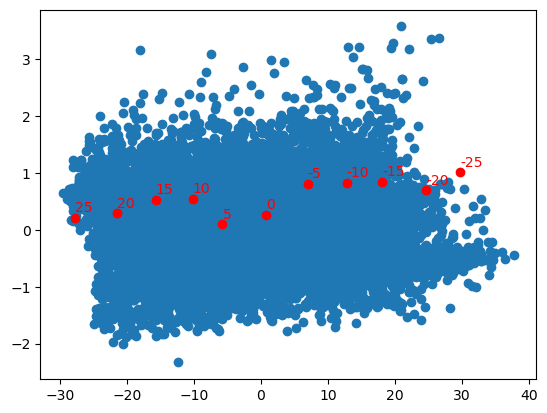

In [7]:
# Visualize observations with calibration dataset via PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(x_cal[:,:,0]) 
x_new = pca.transform(x_cal[:,:,0])

plt.scatter(x_new[:,0],x_new[:,1])
x_new_obs = pca.transform(x_obs_list[:,:,0])
plt.scatter(x_new_obs[:,0],x_new_obs[:,1], color='red')
for i,g in enumerate(gain_list):
    plt.text(x_new_obs[i,0],x_new_obs[i,1]+0.1, str(g), color='red')
plt.show()

#### Local C2ST at $x_0$
We show results obtained for the `MLPClassifier` (with hyperparameters defined in `sbi.utils.metrics`) and for a calibration set of size 12500 (as motivated in the section about the classifier and cal-set choice, 10000 is not enough to get accurate test results).

Results were pre-computed by running `script_margaret_local_c2st.py` with the right set-up.

##### Predict probas at $x_0$

In [13]:
# Load pre-computed results 
probas = []
probas_null = []

for g in gain_list:
    probas.append(torch.load(f'../saved_experiments/JR-NMM/lc2st_results/12500/probas_jrnmm_g_{g}.pkl'))
    probas_null.append(torch.load(f'../saved_experiments/JR-NMM/lc2st_results/12500/probas_null_g_{g}.pkl'))

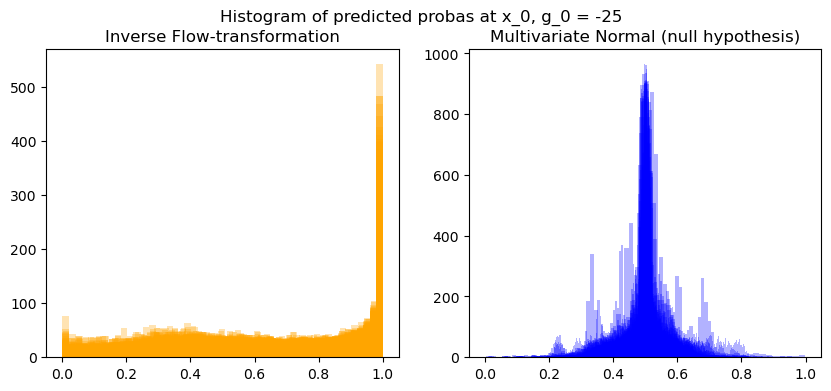

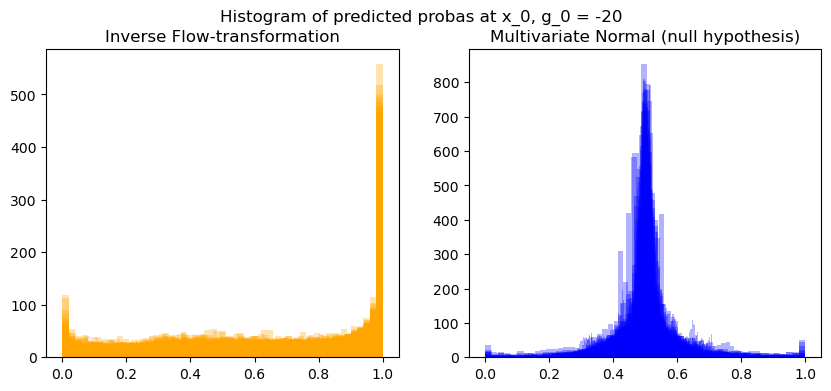

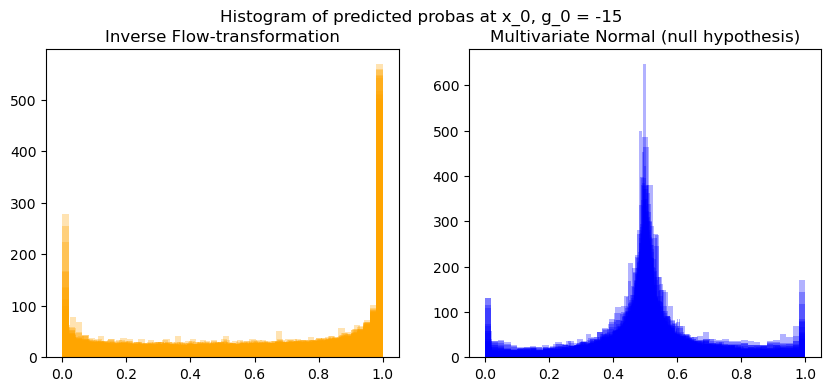

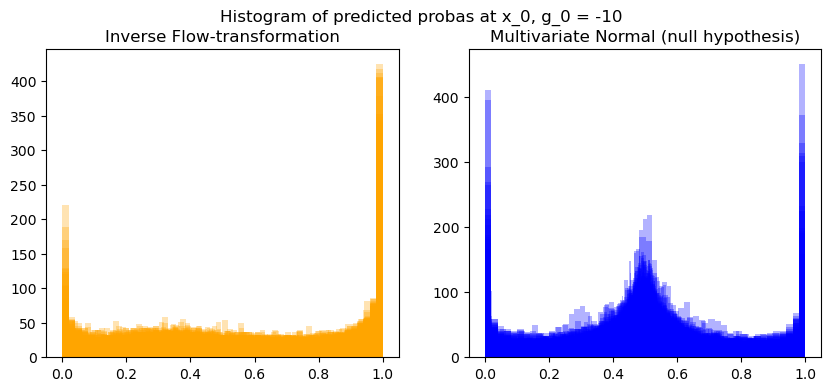

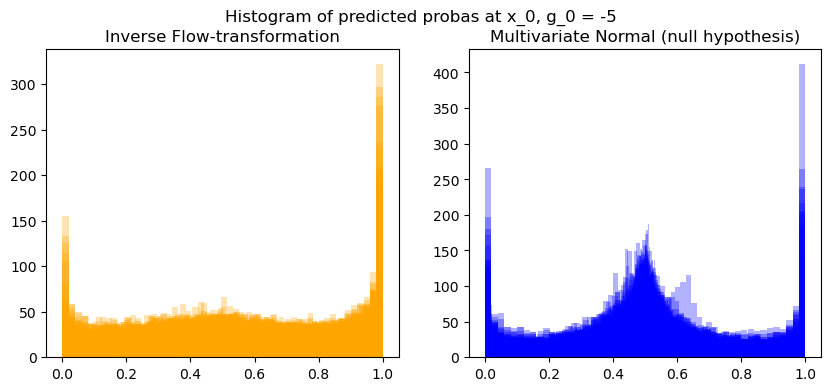

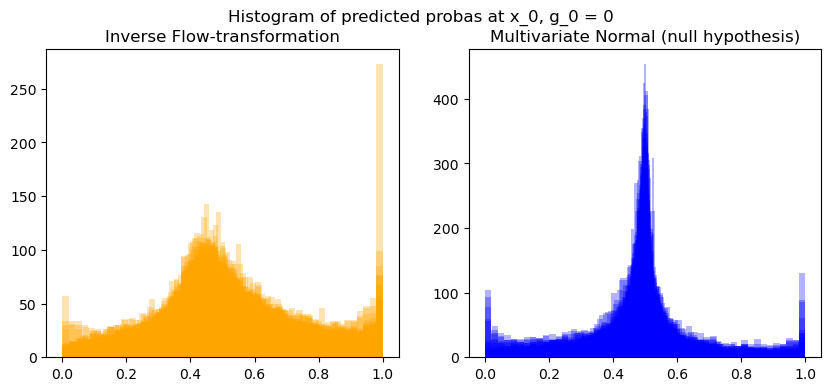

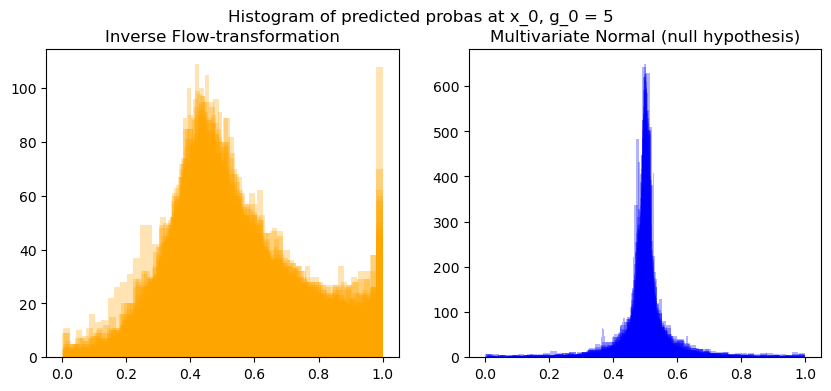

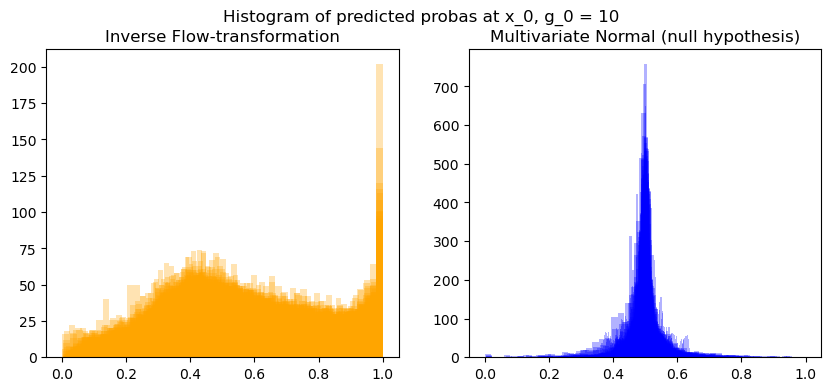

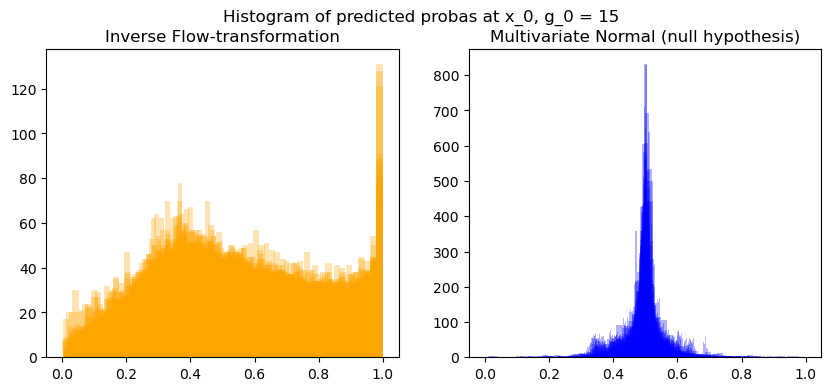

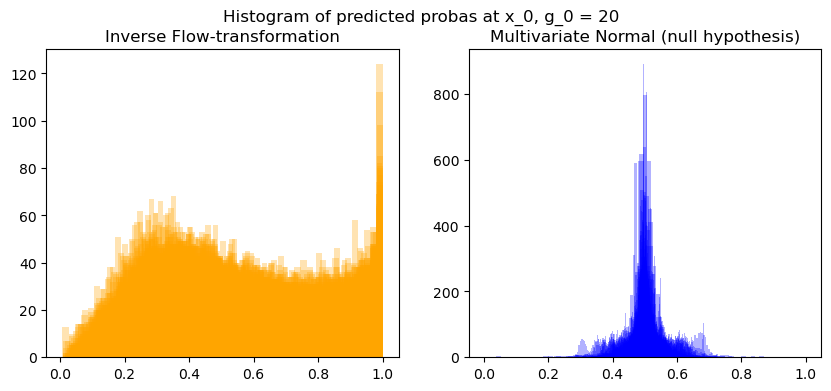

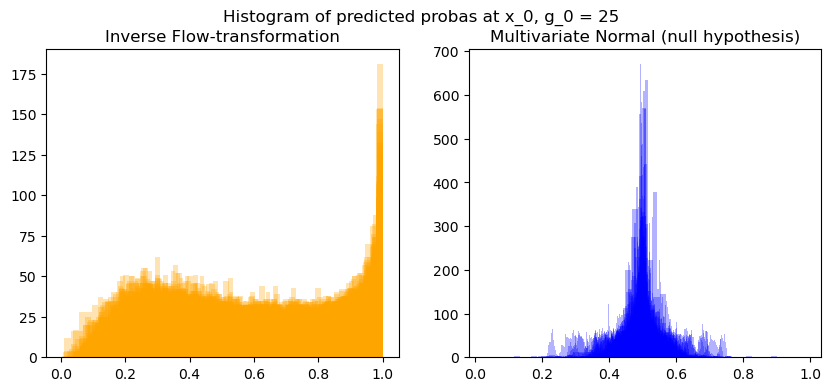

In [14]:
# Plot histograms
n_trials = 1000

plt.rcParams["figure.figsize"] = (10, 4)
for i,g in enumerate(gain_list):
    fig, axs = plt.subplots(1,2)
    for t in range(n_trials):
        axs[0].hist(probas[i][t], alpha=0.3, bins=50, color='orange')
        axs[1].hist(probas_null[i][t], alpha=0.3, bins=50, color='blue')
    axs[0].set_title('Inverse Flow-transformation')
    axs[1].set_title('Multivariate Normal (null hypothesis)')
    plt.suptitle(f'Histogram of predicted probas at x_0, g_0 = {g}')
    plt.show()

##### Hypothesis Test Diagnostics (at confidence level of 95%)


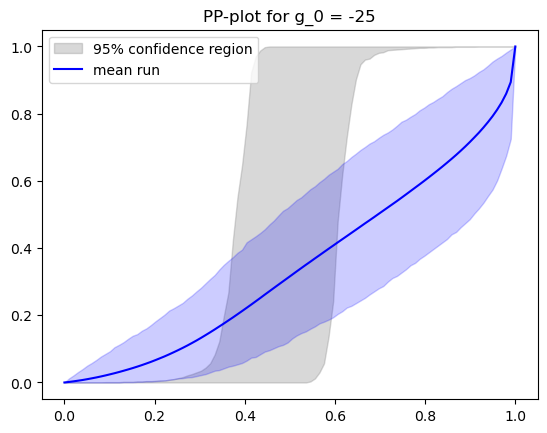

NB samples = 12500
std 0.025448661837384
test stat:  0.11646652201901 w_dist:  0.2754344466194824
p-value:  0.039 p_value_w:  0.001
rejected
rejected (w_dist)


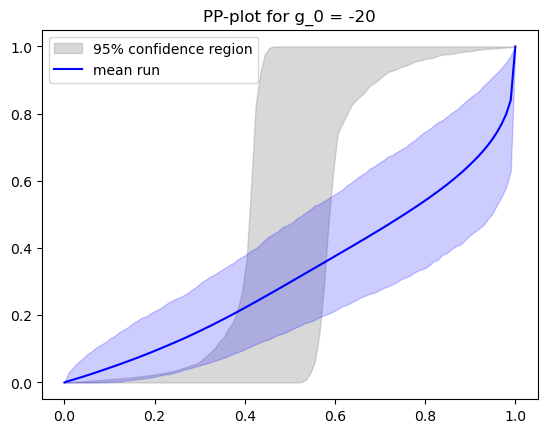

NB samples = 12500
std 0.03762175054010512
test stat:  0.13852877253240997 w_dist:  0.3077094507898661
p-value:  0.01 p_value_w:  0.0
rejected
rejected (w_dist)


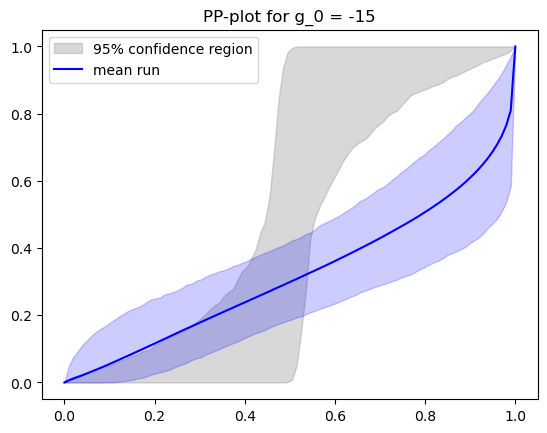

NB samples = 12500
std 0.06461828048358358
test stat:  0.15226826873747 w_dist:  0.32856780491236326
p-value:  0.0 p_value_w:  0.003
rejected
rejected (w_dist)


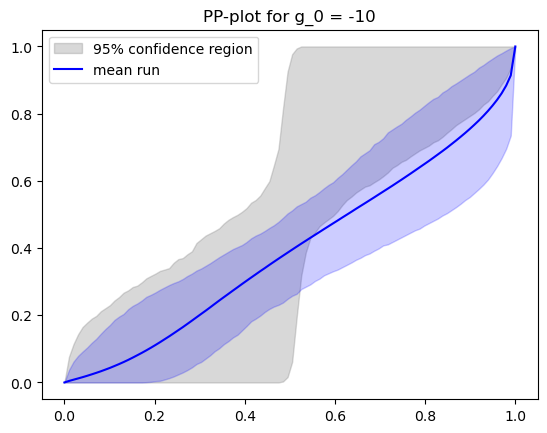

NB samples = 12500
std 0.10144582465141727
test stat:  0.10322145807230002 w_dist:  0.2748897547180062
p-value:  0.044 p_value_w:  0.042
rejected
rejected (w_dist)


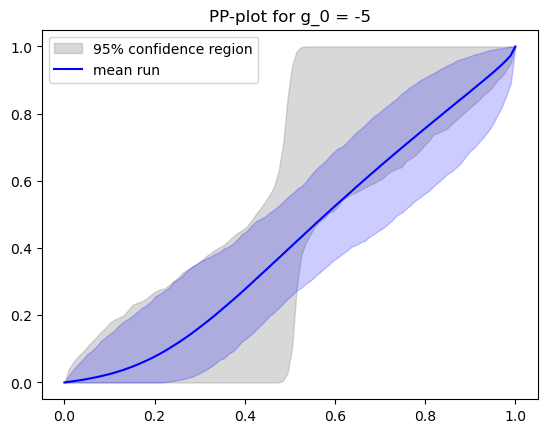

NB samples = 12500
std 0.08762334487734753
test stat:  0.07719115414830999 w_dist:  0.22514072135722688
p-value:  0.064 p_value_w:  0.068
not rejected
not rejected (w_dist)


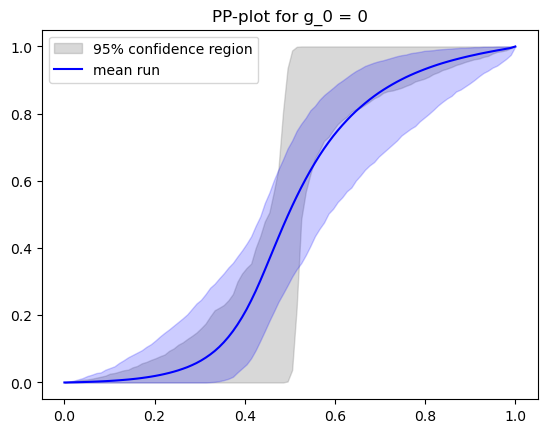

NB samples = 12500
std 0.04495914109777865
test stat:  0.03358416027641998 w_dist:  0.1239865476036044
p-value:  0.056 p_value_w:  0.035
not rejected
rejected (w_dist)


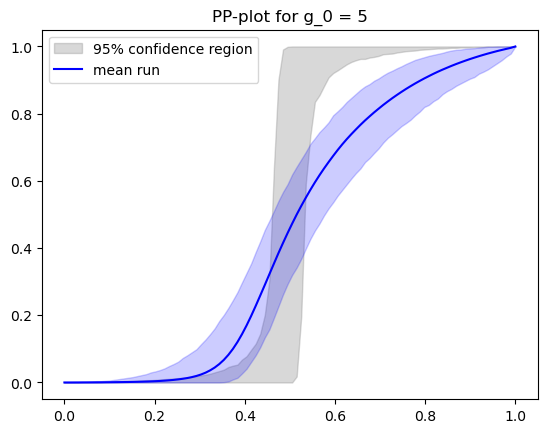

NB samples = 12500
std 0.0199339259875906
test stat:  0.037186330754830015 w_dist:  0.12740097921969287
p-value:  0.031 p_value_w:  0.002
rejected
rejected (w_dist)


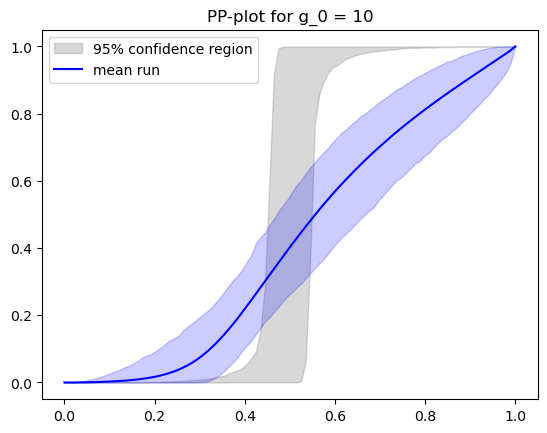

NB samples = 12500
std 0.015102651092624668
test stat:  0.05954788151641996 w_dist:  0.1800174801176908
p-value:  0.027 p_value_w:  0.0
rejected
rejected (w_dist)


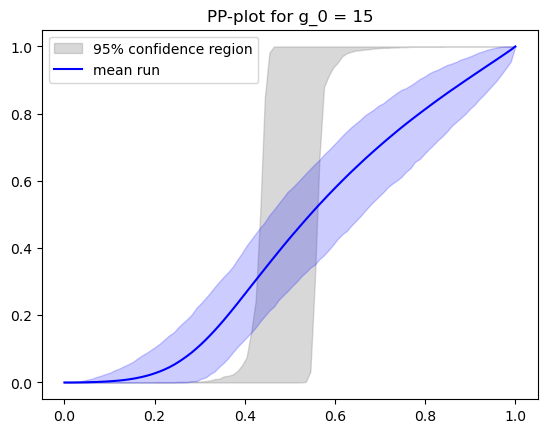

NB samples = 12500
std 0.012604776982312226
test stat:  0.06117447289822 w_dist:  0.18793643811123026
p-value:  0.043 p_value_w:  0.0
rejected
rejected (w_dist)


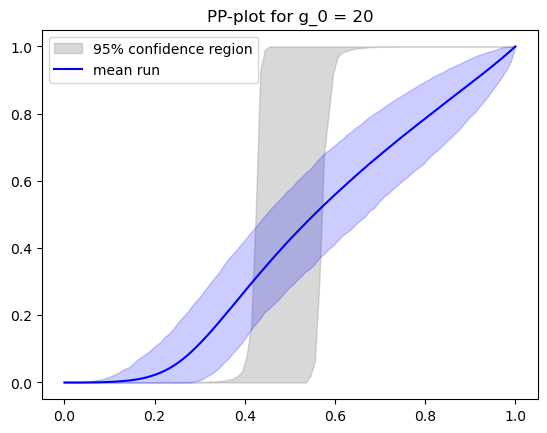

NB samples = 12500
std 0.010554482214831733
test stat:  0.06693688298919004 w_dist:  0.19860972835207183
p-value:  0.051 p_value_w:  0.0
not rejected
rejected (w_dist)


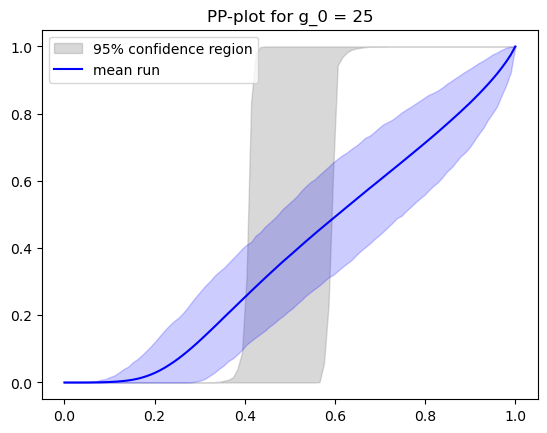

NB samples = 12500
std 0.009505943723708207
test stat:  0.08424467955691002 w_dist:  0.2265786420267903
p-value:  0.055 p_value_w:  0.003
not rejected
rejected (w_dist)


In [16]:
# Plot PP-plots and compute test-statistics/p-values
from diagnostics.pp_plots import PP_vals
from scipy.stats import wasserstein_distance

plt.rcParams.update(plt.rcParamsDefault)

test_stat = {}
w_dist_mean = {}
p_value = {}
p_value_w = {}
reject = {}
reject_w = {}

for i in range(11):

    alphas = np.linspace(0,1,100)
    pp_vals_dirac = PP_vals([0.5]*1000, alphas)

    # nb samples = 10000
    # plt.plot(alphas, pp_vals_dirac, '--', color='black')

    pp_vals_null = {}
    test_stats_null = {}
    w_dist_null = []
    for t in range(len(probas_null[0])):
        pp_vals_null[t] = pd.Series(PP_vals(probas_null[i][t], alphas))
        test_stats_null[t] = ((pp_vals_null[t]- pp_vals_dirac) ** 2).sum() / len(alphas)
        w_dist_null.append(wasserstein_distance([0.5]*1000, probas_null[i][t]))
    
    pp_vals = {}
    w_dist = []
    for t in range(1000):
        pp_vals[t] = pd.Series(PP_vals(probas[i][t], alphas))
        w_dist.append(wasserstein_distance([0.5]*1000, probas[i][t]))

    low_null = pd.DataFrame(pp_vals_null).quantile(0.05/2, axis=1)
    up_null = pd.DataFrame(pp_vals_null).quantile(1-0.05/2, axis=1)
    plt.fill_between(alphas, low_null, up_null, label='95% confidence region', color="grey", alpha=0.3)

    low = pd.DataFrame(pp_vals).quantile(0.05/2, axis=1)
    up = pd.DataFrame(pp_vals).quantile(1-0.05/2, axis=1)
    line = pd.DataFrame(pp_vals).mean(axis=1)
    plt.plot(alphas, line, label='mean run', color='blue')
    plt.fill_between(alphas, low, up, color="blue", alpha=0.2)
    plt.legend()
    plt.title(f'PP-plot for g_0 = {gain_list[i]}')
    plt.show()


    test_stat[i] = ((line - pp_vals_dirac) ** 2).sum() / len(alphas)
    p_value[i] = sum(1 * (test_stat[i] < pd.Series(test_stats_null))) / len(test_stats_null)

    w_dist_mean[i] = np.mean(w_dist)
    p_value_w[i] = sum(1 * (w_dist_mean[i] < pd.Series(w_dist_null))) / len(w_dist_null)
    
    print('NB samples = 12500')
    print('std', pd.DataFrame(probas_null[i]).std(axis=1).mean())
    print('test stat: ', test_stat[i], 'w_dist: ', w_dist_mean[i])
    print('p-value: ', p_value[i], 'p_value_w: ', p_value_w[i])
    if p_value[i] <= 0.05:
        print('rejected')
        reject[i] = True
    else:
        print('not rejected')
        reject[i] = False
    
    if p_value_w[i] <= 0.05:
        print('rejected (w_dist)')
        reject_w[i] = True
    else:
        print('not rejected (w_dist)')
        reject_w[i] = False

In [18]:
# Show test results in dataframe
df_results = {}
df_results['TV_dist'] = pd.DataFrame({
    'test_stat': test_stat, 
    'p_value': p_value, 
    'rejected': reject 
})
df_results['w_dist'] = pd.DataFrame({
    'test_stat': w_dist_mean, 
    'p_value': p_value_w, 
    'rejected': reject_w 
})
pd.concat({k: pd.DataFrame(v).T for k, v in df_results.items()}, axis=0)

0         1         2         3         4         5   \
TV_dist test_stat  0.116467  0.138529  0.152268  0.103221  0.077191  0.033584   
        p_value       0.039      0.01       0.0     0.044     0.064     0.056   
        rejected       True      True      True      True     False     False   
w_dist  test_stat  0.275434  0.307709  0.328568   0.27489  0.225141  0.123987   
        p_value       0.001       0.0     0.003     0.042     0.068     0.035   
        rejected       True      True      True      True     False      True   

                         6         7         8         9         10  
TV_dist test_stat  0.037186  0.059548  0.061174  0.066937  0.084245  
        p_value       0.031     0.027     0.043     0.051     0.055  
        rejected       True      True      True     False     False  
w_dist  test_stat  0.127401  0.180017  0.187936   0.19861  0.226579  
        p_value       0.002       0.0       0.0       0.0     0.003  
        rejected       True      True      True      True      True

The TV_dist fails to reject more often than w_dist, which makes w_dist more powerful (this can also be seen in the section about "precision under the null-hypothsis - cal-set choice).

### Choice of classification model and cal-set size

#### Accuracy - Shift-experiment
Results were pre-computed by running `script_margaret_local_c2st.py` with the right set-up. We still need to add results for `'lda'` and `'qda'`.

In [19]:
# Load precomputed results 
N = [1000, 2000, 5000, 10000]
dfs_mean = {}
dfs_scale = {}
for n in N:
    dfs_mean[n] = torch.load(f'../saved_experiments/JR-NMM/lc2st_eval_clfs/df_mean_{n}.pkl')
    dfs_scale[n] = torch.load(f'../saved_experiments/JR-NMM/lc2st_eval_clfs/df_scale_{n}.pkl')

##### Mean-shift

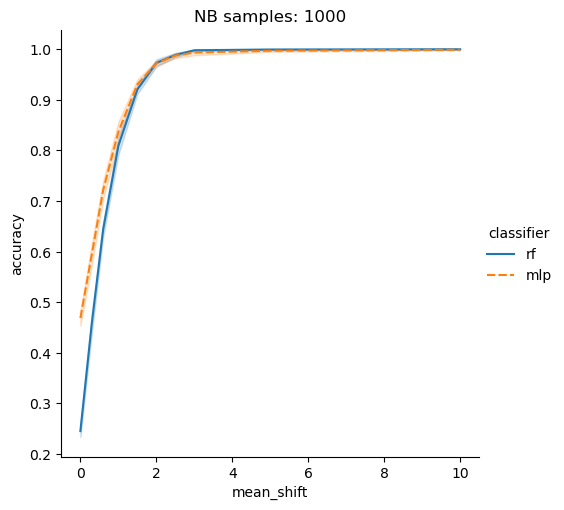

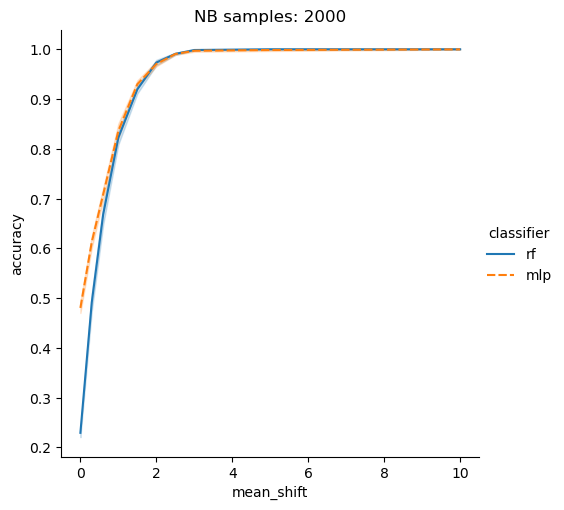

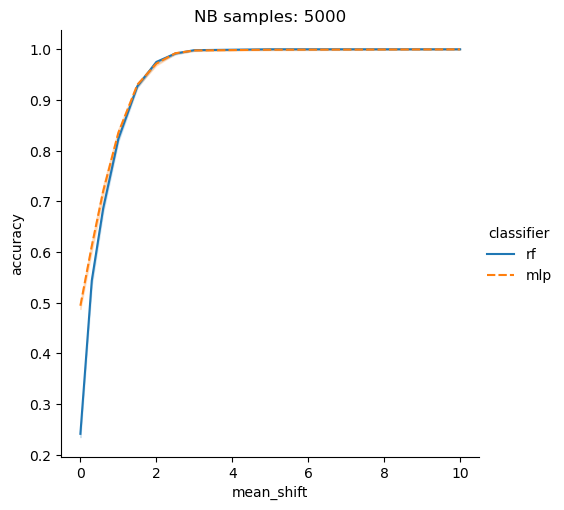

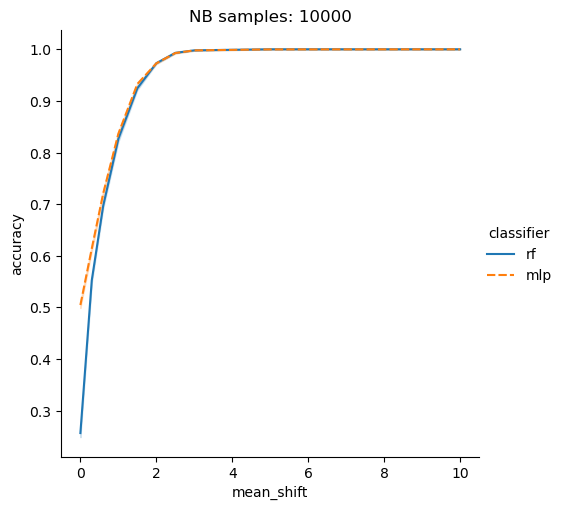

In [20]:
import seaborn as sns
for n in N:
    sns.relplot(
        data=dfs_mean[n], x="mean_shift", y="accuracy",
        hue="classifier", style="classifier", kind="line",
    )
    plt.title(f'NB samples: {n}')
    plt.show()

##### Scale-shift


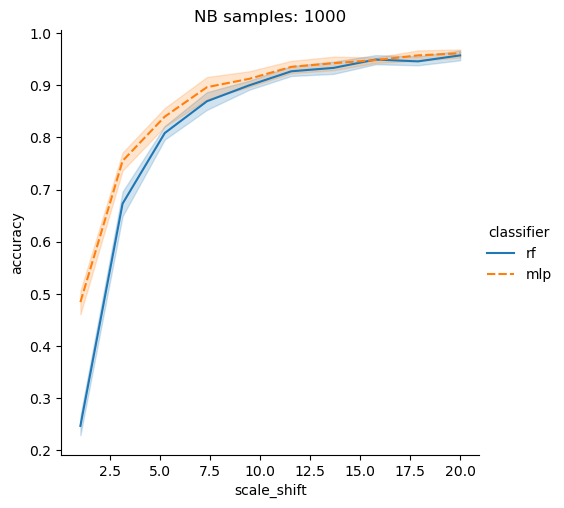

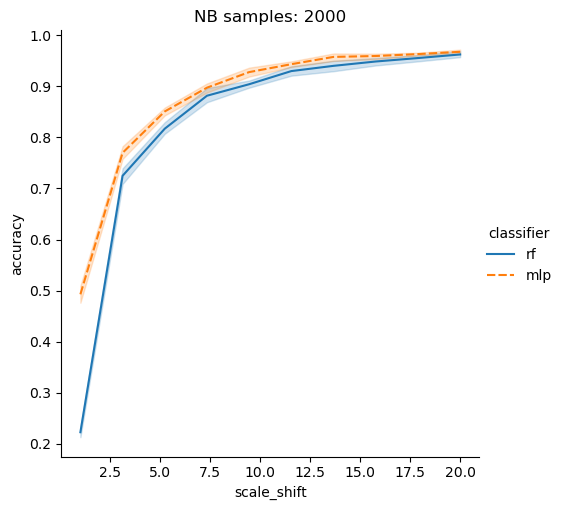

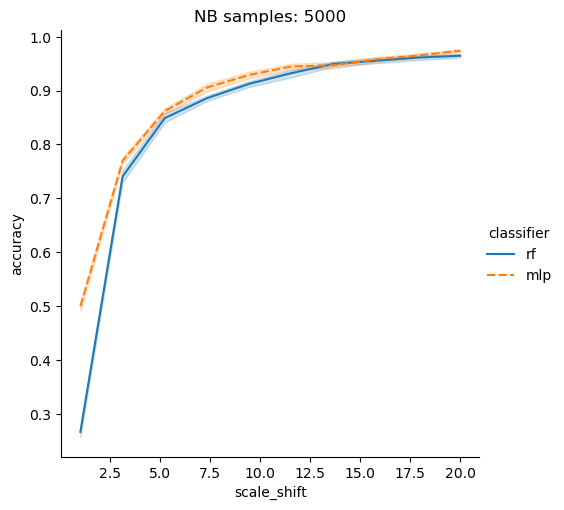

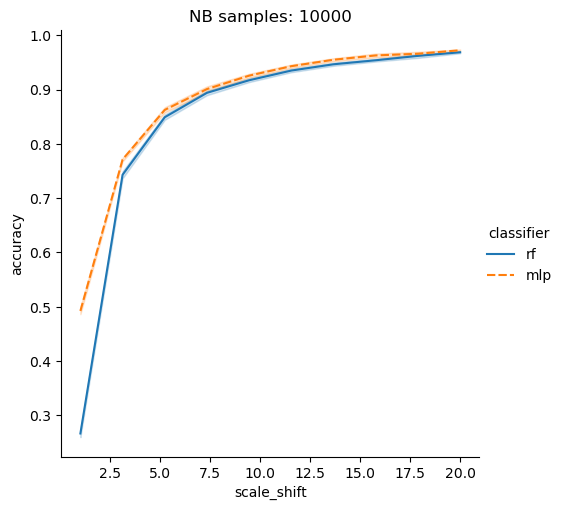

In [21]:
for n in N:
    sns.relplot(
        data=dfs_scale[n], x="scale_shift", y="accuracy",
        hue="classifier", style="classifier", kind="line",
    )
    plt.title(f'NB samples: {n}')
    plt.show()

#### Precision under the null hypothesis - cal-set size
Results were pre-computed by running `script_margaret_local_c2st.py` with the right set-up.


test_stats



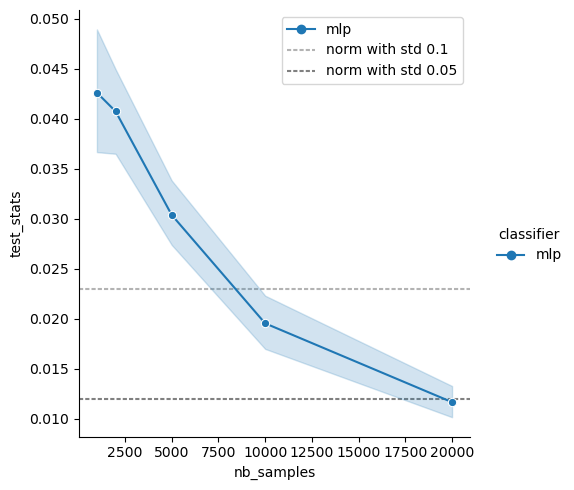


w_dist



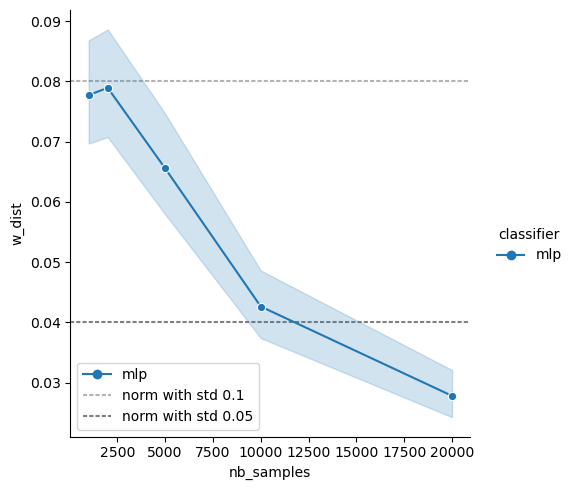


test_stats



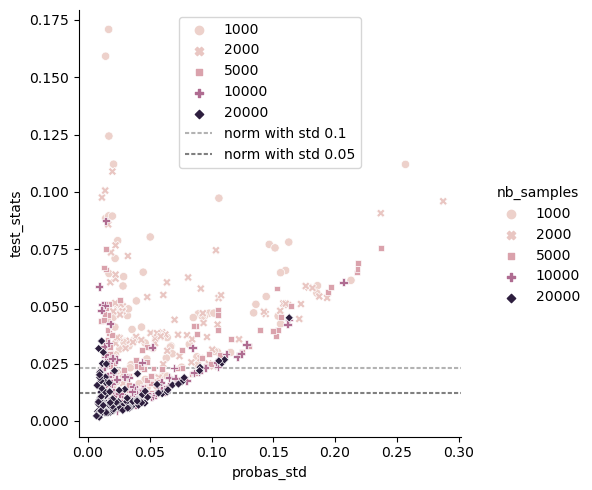


w_dist



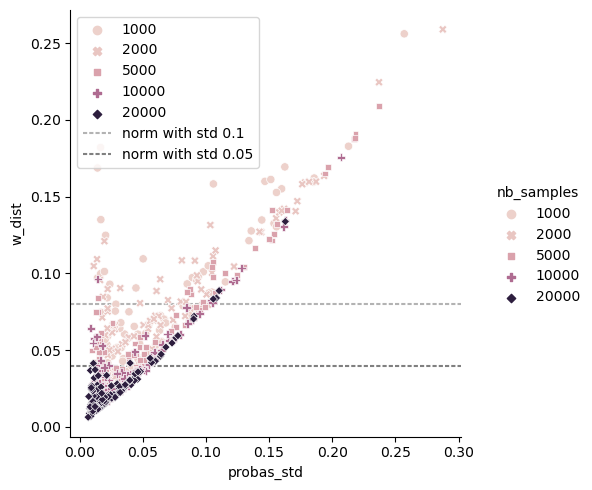

In [23]:
dfs = []
for n in [1000, 2000, 5000, 10000, 20000]: #, 50000]:
    dfs.append(torch.load(f'../saved_experiments/JR-NMM/lc2st_eval_clfs/df_null_std_cv_n_[{n}]_ntrials_100_Tstats_wdist.pkl'))

df = pd.concat(dfs, ignore_index=True)

for T, y1, y2 in zip(['test_stats', 'w_dist'], [0.023,0.08], [0.012, 0.04]):
    print()
    print(T)
    print()
    g = sns.relplot(
            data=df, x="nb_samples", y=T,
            hue="classifier", style="classifier", kind="line", markers='o'
        )
    g.map(plt.axhline, y=y1, color=".7", dashes=(2, 1), zorder=0, label='norm with std 0.1')
    g.map(plt.axhline, y=y2, color=".5", dashes=(2, 1), zorder=0, label='norm with std 0.05')
    plt.legend()
    plt.show()


for T, y1, y2 in zip(['test_stats', 'w_dist'], [0.023,0.08], [0.012, 0.04]):
    print()
    print(T)
    print()
    g = sns.relplot(
            data=df, x="probas_std", y=T,
            hue="nb_samples", style="nb_samples", kind="scatter", 
        )
    g.map(plt.axhline, y=y1, color=".7", dashes=(2, 1), zorder=0, label='norm with std 0.1')
    g.map(plt.axhline, y=y2, color=".5", dashes=(2, 1), zorder=0, label='norm with std 0.05')
    plt.legend()
    plt.show()
    df[df[T]<=y1]['probas_std'].max(), df[df[T]<=y2]['probas_std'].max()

Results:
- plot 1 - TV_dist: the wanted test statistics are obtained for a sample size of 10_000 (for 0.1 std) and 20_000 (for 0.05 std)
- plot 2 - w_dist: the wanted test statistics are obtained for a sample size of ~12_500 (for 0.05 std) and always fpr 0.1 std
- plot 3/4: Larger sample sizes ensure small test statistics for small stds (closer to theory). For the TV_dist, there are still data points with predicted stds that are above the theory (points with test stat below the line but with std larger than 0.05/0.1), this is not really the case for w_dist. 

1. The wasserstein distance seems to lead to statistically more powerful tests (less data needed to get narrow confidence regions).

2. What sample size do we chose? 
- the shift experiment showed us that good accuracy is obtained (with precision) for sample sizes above 5000 (cf. scale shift: smooth accuracy curve with narrow CV-std and where mlp consistently above rf). We would say 10000 is appropriate. 
- looking at the precision under the null-hypothesis, 10000 seems to lead to results with still pretty high and dispersed stds / test-statistics. I would propose a sample size of 
    -  12500 if we are short on simulations (here the w_dist test stat is already quite close to the theoretical test statistic of the 0.05 std gaussian), 
    - 20000 if simulations are not a problem (to get even more precise results).